# IA & Data science  -- 2020-2021


## Données

Les données vous sont fournies sur le moodle. 
Ces données sont fournies sur Kaggle, ce sont les données *Google Play Store Apps* accessibles à l'adresse https://www.kaggle.com/lava18/google-play-store-apps.

Il est indispensable de lire en détail la page Kaggle pour comprendre à quoi ces données correspondent.

Le compte-rendu a fournir le jour de la dernière séance de TDTME de votre groupe doit comporter:
- un fichier PDF qui correspond à un poster sur lequel sont expliqués les différents problèmes traités, la façon dont ils ont été traités, et les résultats obtenus.
- un notebook par problème traité, vous pouvez traiter autant de problème que vous le souhaitez. Le problème étudié doit être décrit précisément et vous devez impérativement suivre le format ci-dessous.

Bien entendu, le tout sera mis dans un fichier archive (tar.gz ou zip exclusivement) et déposé sur le site Moodle.


Format à suivre:

## Dans ce notebook on va faire une classification de sentiments sur le dataset  googleplaystore_user_reviews

 # **<font color="RED"> Les importation </font>**

In [224]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf

import string
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import timeit

In [225]:
import sys 
sys.path.append("../src")
from iads import evaluation
from iads import *
from text_processing import get_text_words, CountVectorizer, TFIDFVectorizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  **<font color="RED">  Variables globals </font>**

In [226]:
DATA_DIR = "../data"

# **<font color="RED"> Load Dataset </font>**

In [227]:
df = pd.read_csv(f'{DATA_DIR}/googleplaystore_user_reviews.csv')
n, m = df.shape
print(f"On a {n} lignes dans le dataset `googleplaystore_user_reviews` et {m} colonnes.")

On a 64295 lignes dans le dataset `googleplaystore_user_reviews` et 5 colonnes.


In [228]:
df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [229]:
# On elimine toutes les lignes None dans la column Review
df = df[~df['Translated_Review'].isna()]

# on prend que la column Sentiment et Translated_Review
df = df[["Translated_Review", "Sentiment"]]

df = df.rename({'Translated_Review': 'Review'}, axis=1) # on renome la colonne car le nom est tres long


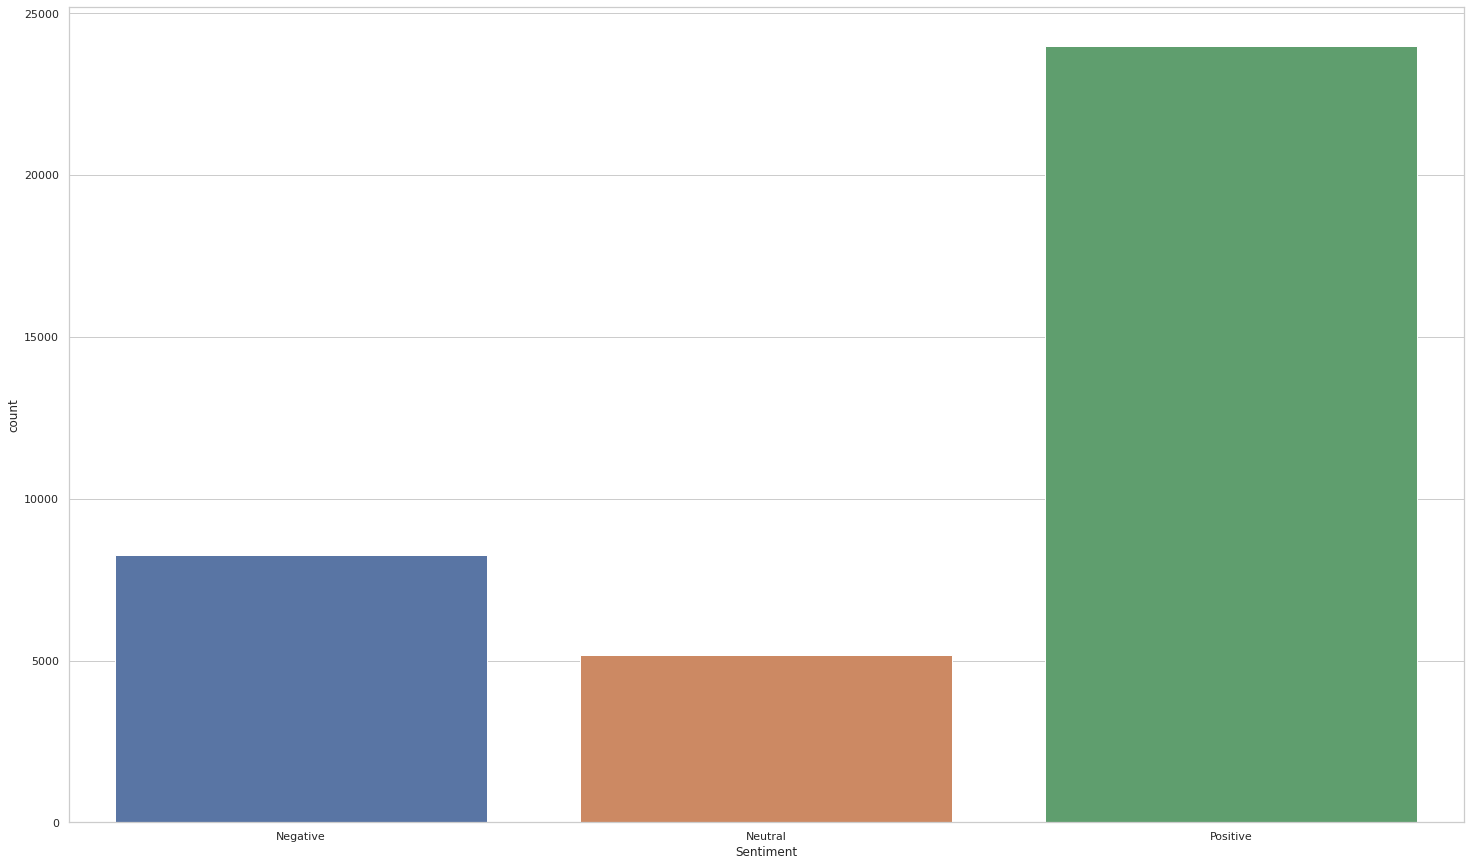

In [230]:
sns.set_theme(style="whitegrid")
d = df.groupby('Sentiment', as_index=False)[['Review']].count().rename({'Review': 'count'}, axis=1)
ax = sns.barplot(x="Sentiment", y="count", data=d)

Cette figure montre la repartition des classes sur notre dataset et on remarque  que la classe "postitif" est bcp plus presente que les deux autre classse donc on est dans un probleme d'un umbalanced dataset

### Split en train, dev et test

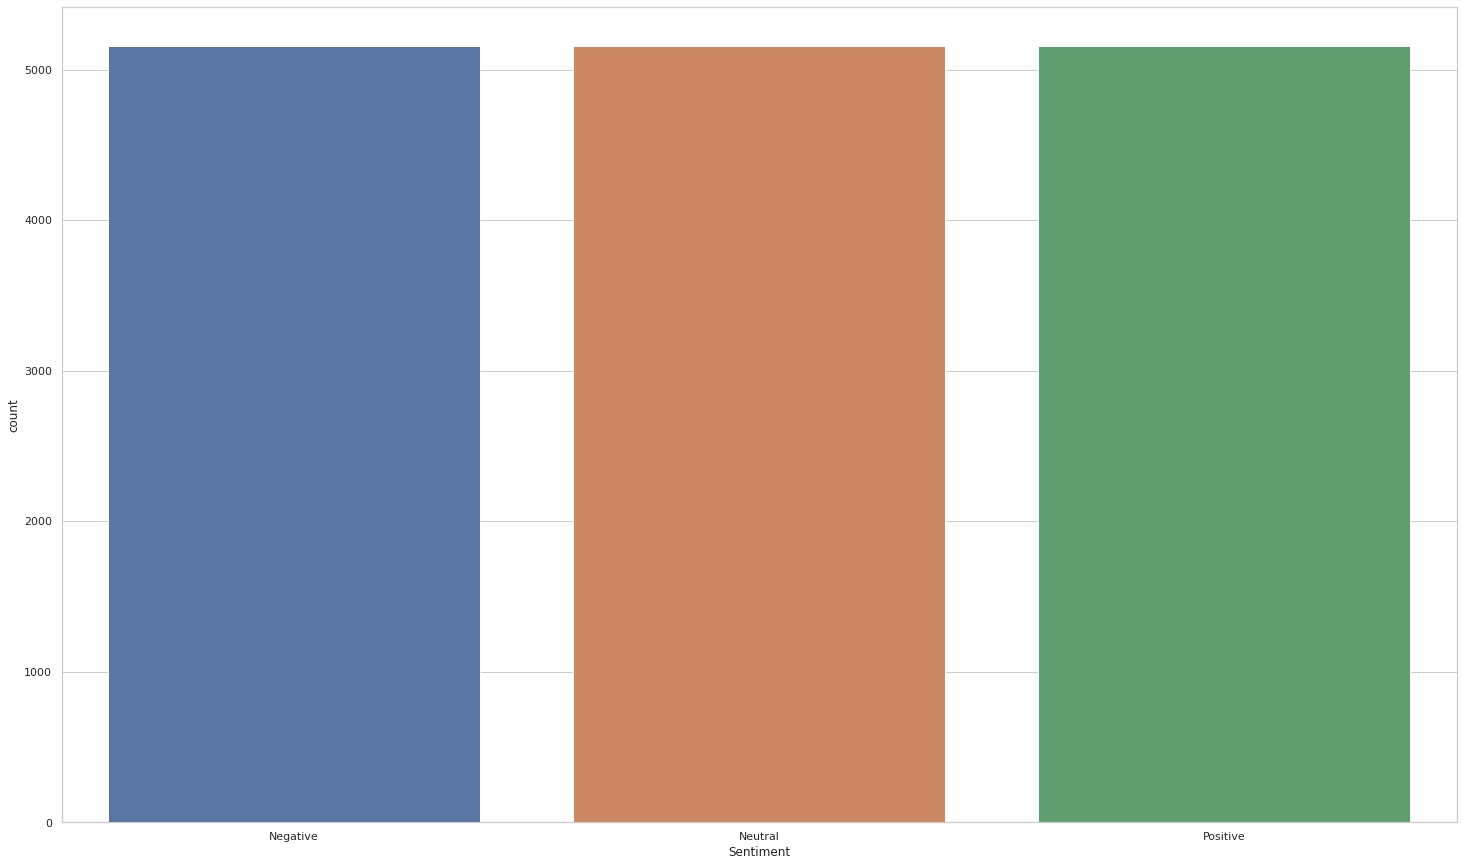

In [231]:
#On prend de cachaque classe un nombre d'individue eqavalent à la taille de la plus petite classe 
random_state = 42

df_pos = df[df['Sentiment']=="Positive"]  # la partition du dataset ou  la classe est positive 
df_neg = df[df['Sentiment']=="Negative"]   # la partition du dataset ou  la classe est negative  
df_nat = df[df['Sentiment']=="Neutral"]     # la partition du dataset ou  la classe est neutre 

length = min((len(df_nat), len(df_pos), len(df_neg))) # la taille minimale des dataset 

df_tmp_pos = df_pos.sample(length, random_state=random_state) # un sous df aléatoirement choisie 
df_tmp_neg = df_neg.sample(length, random_state=random_state)
df_tmp_nat = df_nat.sample(length, random_state=random_state)
 
dataset = pd.concat([df_tmp_nat, df_tmp_pos, df_tmp_neg]) # on rassemble les sous df


# Pour verifier 
sns.set_theme(style="whitegrid")
d = dataset.groupby('Sentiment', as_index=False)[['Review']].count().rename({'Review': 'count'}, axis=1)
ax = sns.barplot(x="Sentiment", y="count", data=d)

In [232]:
train = dataset.sample(frac=0.8,random_state=random_state)  # un sous dataframe pour le test avec 80% d'individus du dataset initial 
test  = dataset.drop(train.index)  # le rest c'est pour le test 
count = train.Sentiment.value_counts() 
print(f"Train: Positive: {count.Positive}, Negative: {count.Negative}, Neutral: {count.Neutral} and total: {len(train)}")
count = test.Sentiment.value_counts()
print(f"Test: Positive: {count.Positive}, Negative: {count.Negative}, Neutral: {count.Neutral} and total: {len(test)}")

Train: Positive: 4123, Negative: 4098, Neutral: 4158 and total: 12379
Test: Positive: 1035, Negative: 1060, Neutral: 1000 and total: 3095


### Processing de text

#### L'objectif de ce precessing est de cree un vecteur qui represent le text pour pouvoir predir le sentiment a partir de ce vecteur

#####  De premier lieu on va creer un vocabulaire pour pouvoir representer notre text

In [233]:

def get_all_occur_tokens(text_repr_l):
    occur = dict() # on crée un dictionnair pour stocker les mots et leurs occurences 
    for text_rpr in text_repr_l: # pour chaque dictionnaire dans text_repr_l
        for w, oc in text_rpr.items(): # on récupère les motes et leurs nombre d'occurences 
            occur[w] = occur.get(w, 0) + oc # on mets à jours l'entré dans le dictionnair global si elle n'existe pas : 0
    return Counter(occur) # on renvoie une collection 


reviews = train.Review.apply(get_text_words).values  # la liste des dictionnaire des mot avec leur occurence dans le train 


reviews_neg = train[train["Sentiment"]=="Negative"].Review.apply(get_text_words).values # la liste des dictionnaire des mots et leur occurnce pour les review negatifs 
reviews_pos = train[train["Sentiment"]=="Positive"].Review.apply(get_text_words).values
reviews_nat = train[train["Sentiment"]=="Neutral"].Review.apply(get_text_words).values


occurs_pos = get_all_occur_tokens(reviews_pos) # la collection des mot et leurs occurence dans les reviews positives
occurs_neg = get_all_occur_tokens(reviews_neg)
occurs_nat = get_all_occur_tokens(reviews_nat)
occurs = get_all_occur_tokens(reviews)        # la collection des mot et leurs occurence dans toutes les reviews

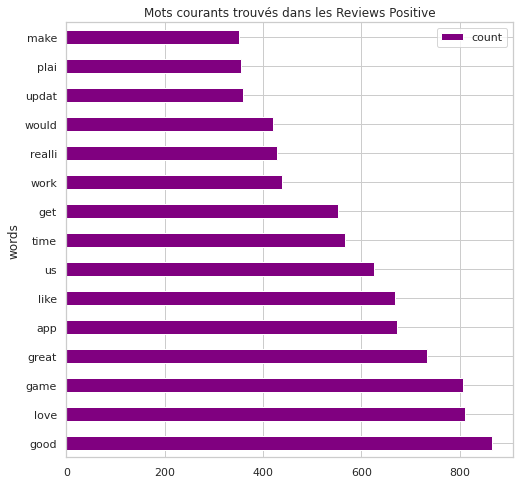

In [234]:
clean_tweets_nsw = pd.DataFrame(occurs_pos.most_common(15),columns=['words', 'count']) # on crée un dataframe pour les 15 mot les plus récurents


fig, ax = plt.subplots(figsize=(8, 8))  


clean_tweets_nsw.plot.barh(x='words',y='count',ax=ax,color="purple")

ax.set_title("Mots courants trouvés dans les Reviews Positive")

plt.show()


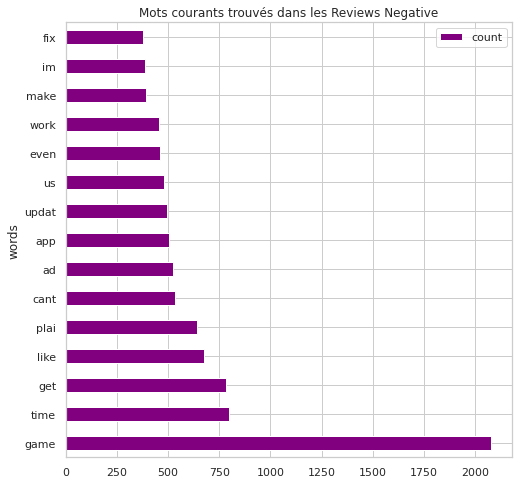

In [235]:
clean_tweets_nsw = pd.DataFrame(occurs_neg.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.plot.barh(x='words',y='count',ax=ax,color="purple")

ax.set_title("Mots courants trouvés dans les Reviews Negative")

plt.show()

#### Commentair: 
On voit que y a des mot qui sont plutot positifs dans le dexième graphe( les mots des reviews negative) come "like"
mais cela est du à la foction du traitement du text , en fait lors de l'application de cette fonction on supprime
les mot qui ne donne pas d'information comme par exemple : the , a , an .. et la pour le mot like suremement à l'origine 
dans les reviews il était : dont like 

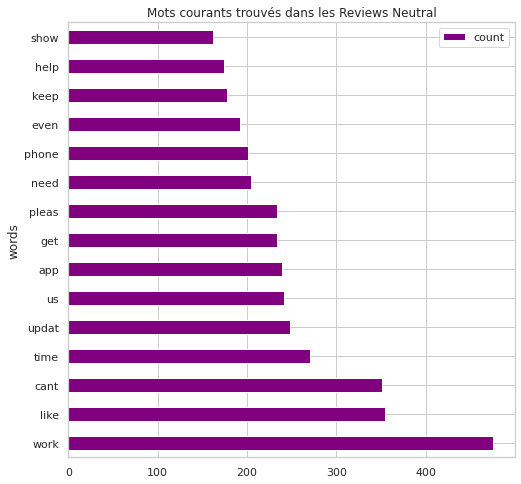

In [236]:
clean_tweets_nsw = pd.DataFrame(occurs_nat.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

clean_tweets_nsw.plot.barh(x='words',y='count',ax=ax,color="purple")

ax.set_title("Mots courants trouvés dans les Reviews Neutral")

plt.show()

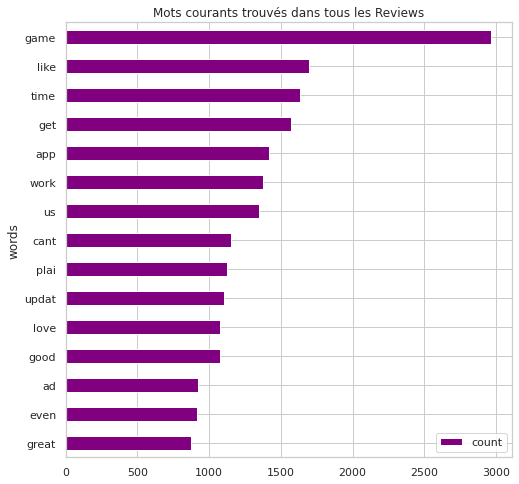

In [237]:
clean_tweets_nsw = pd.DataFrame(occurs.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Mots courants trouvés dans tous les Reviews")

plt.show()

## Classification binaire avec CountVectorizer

In [238]:
# on se ramène a une classification binaire donc on prend que les exemple ou le sentiment est + ou - 
train_bin = train[train.Sentiment != "Neutral"] # le dataser du train  
test_bin = test[test.Sentiment != "Neutral"] # le dataset de test 
  
print(train_bin.Sentiment.unique()) # on a maitenant que positif et negatif 

# On elimine les mots qui ont un nombre d'occurence trés faible on chosit 10 comme seuil
# pour limiter un peu notre vocabulair et eviter le surapprentissage 

seuil = 10

vectorizer = CountVectorizer(min_df=seuil)
X_train = vectorizer.fit_transform(train_bin.Review)
X_test = vectorizer.transform(test_bin.Review)

target2id = {
    "Negative":-1,
    "Positive":1
}

y_train = train_bin.Sentiment.apply(lambda x: target2id[x]).values
y_test = test_bin.Sentiment.apply(lambda x: target2id[x]).values

print(f"En eliminant tous les mots qui ont un nombre d'occurence inferieur à {seuil} on obtient un vocabulaire contenant {len(vectorizer.vocabulary)} mots.")

['Negative' 'Positive']


100%|██████████| 2095/2095 [00:00<00:00, 71491.88it/s]

En eliminant tous les mots qui ont un nombre d'occurence inferieur à 10 on obtient un vocabulaire contenant 1575 mots.


### ClassifierLineaireRandom

In [239]:
classifierlineairerandom = ClassifierLineaireRandom(X_train.shape[1]) # on construit un classifier random 

In [240]:
tic = timeit.default_timer() # heure de départ
classifierlineairerandom.train(X_train, y_train) # on entraine le classifier 
classifierlineairerandom.accuracy(X_test, y_test)  

0.5078758949880668

In [241]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.21189 secondes


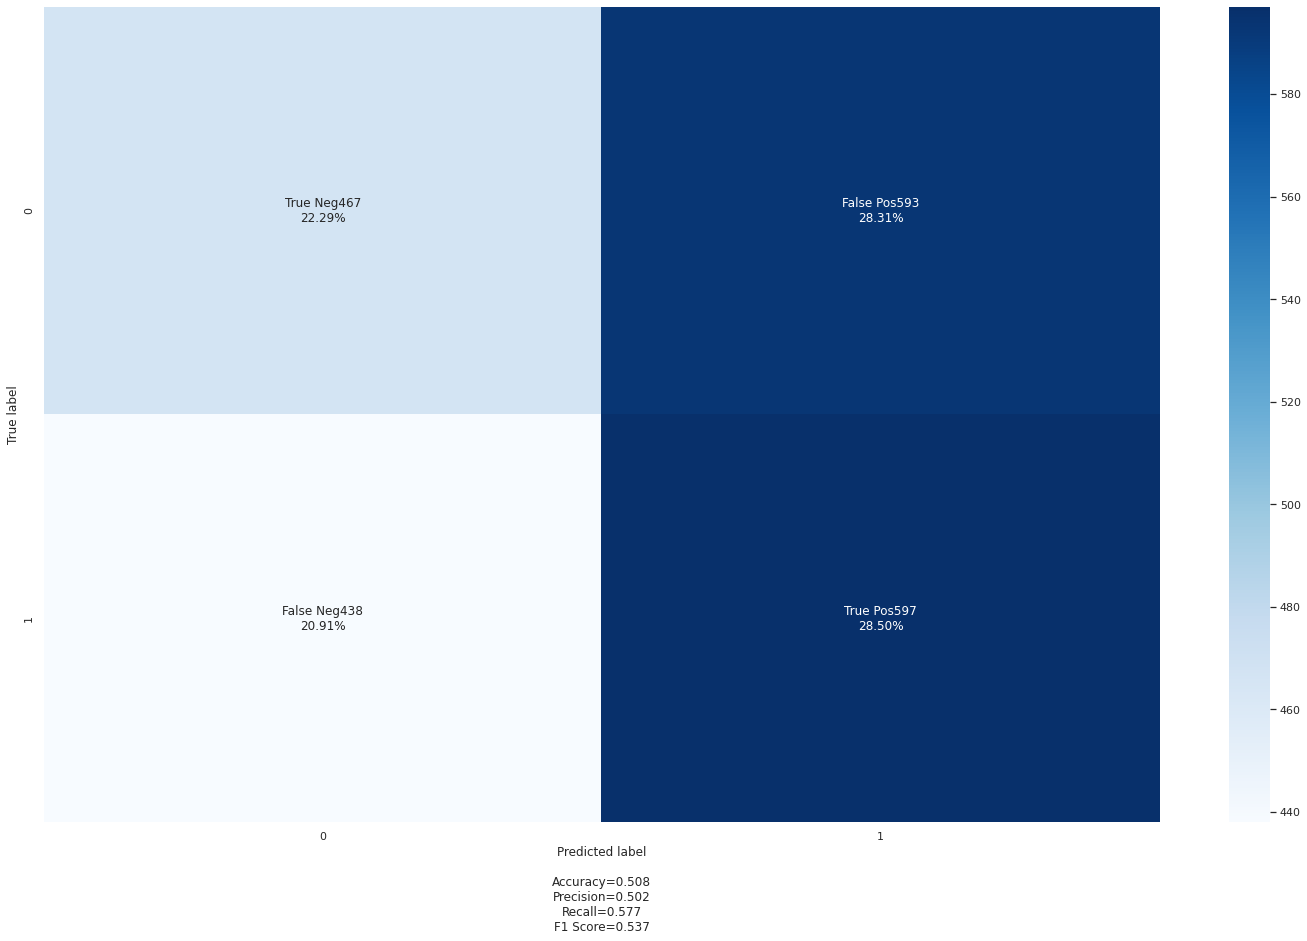

In [242]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierlineairerandom.predict(X_test))

### ClassifierKNN

In [243]:
classifierknn = ClassifierKNN(X_train.shape[1], 5) # avec k =5

tic = timeit.default_timer() # heure de départ
classifierknn.train(X_train, y_train)
classifierknn.accuracy(X_test, y_test)


0.7360381861575179

In [244]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 1.66284 secondes


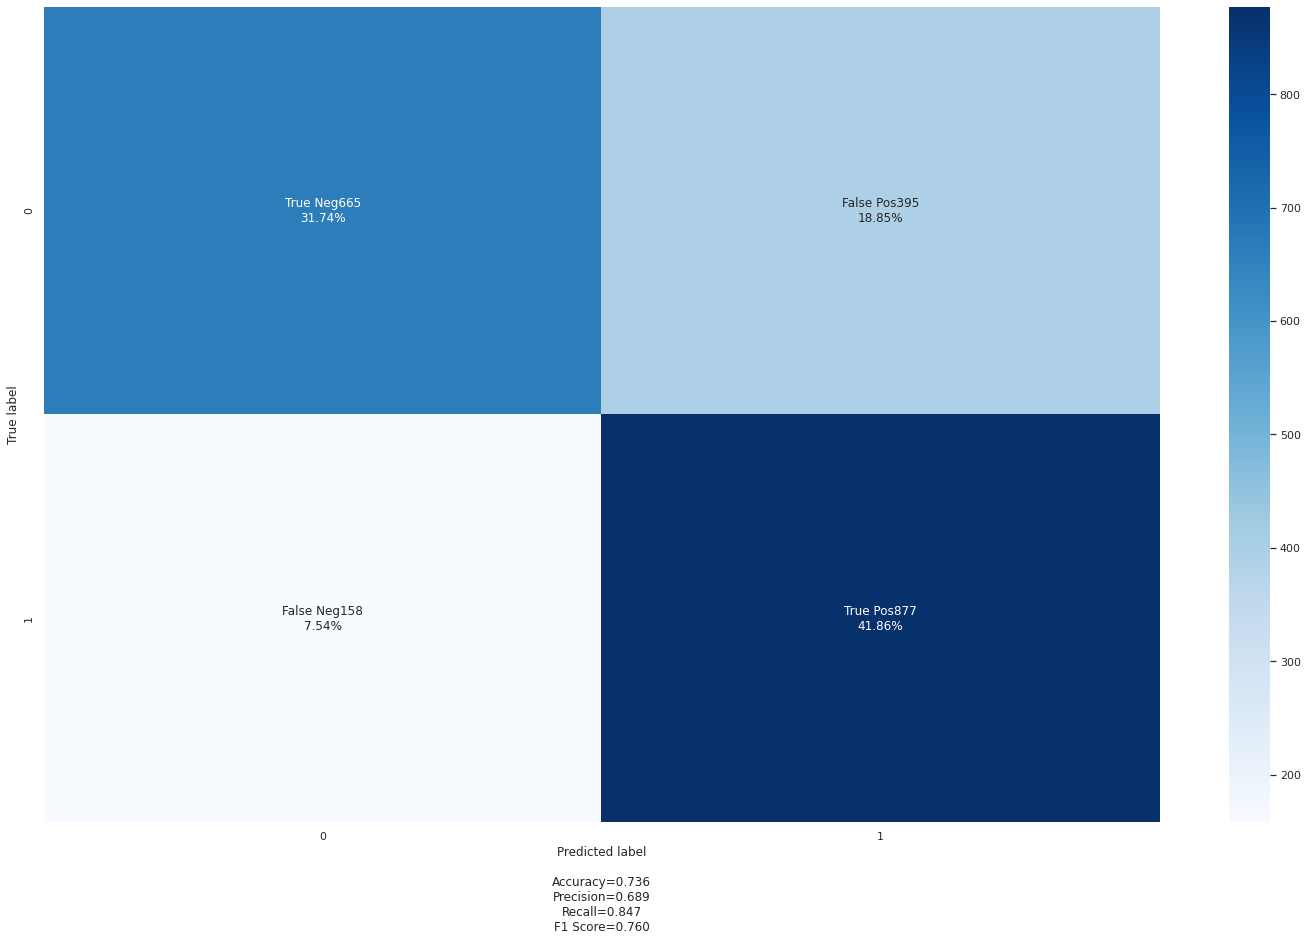

In [245]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierknn.predict(X_test))

### ClassifierPerceptron

In [246]:

classifierperceptron = ClassifierPerceptron(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-2, 
    batch_size=64,  
    epochs=10 
) 

In [247]:
tic = timeit.default_timer() # heure de départ
classifierperceptron.train(X_train, y_train)

In [248]:
classifierperceptron.accuracy(X_test, y_test)

0.8735083532219571

In [249]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.75693 secondes


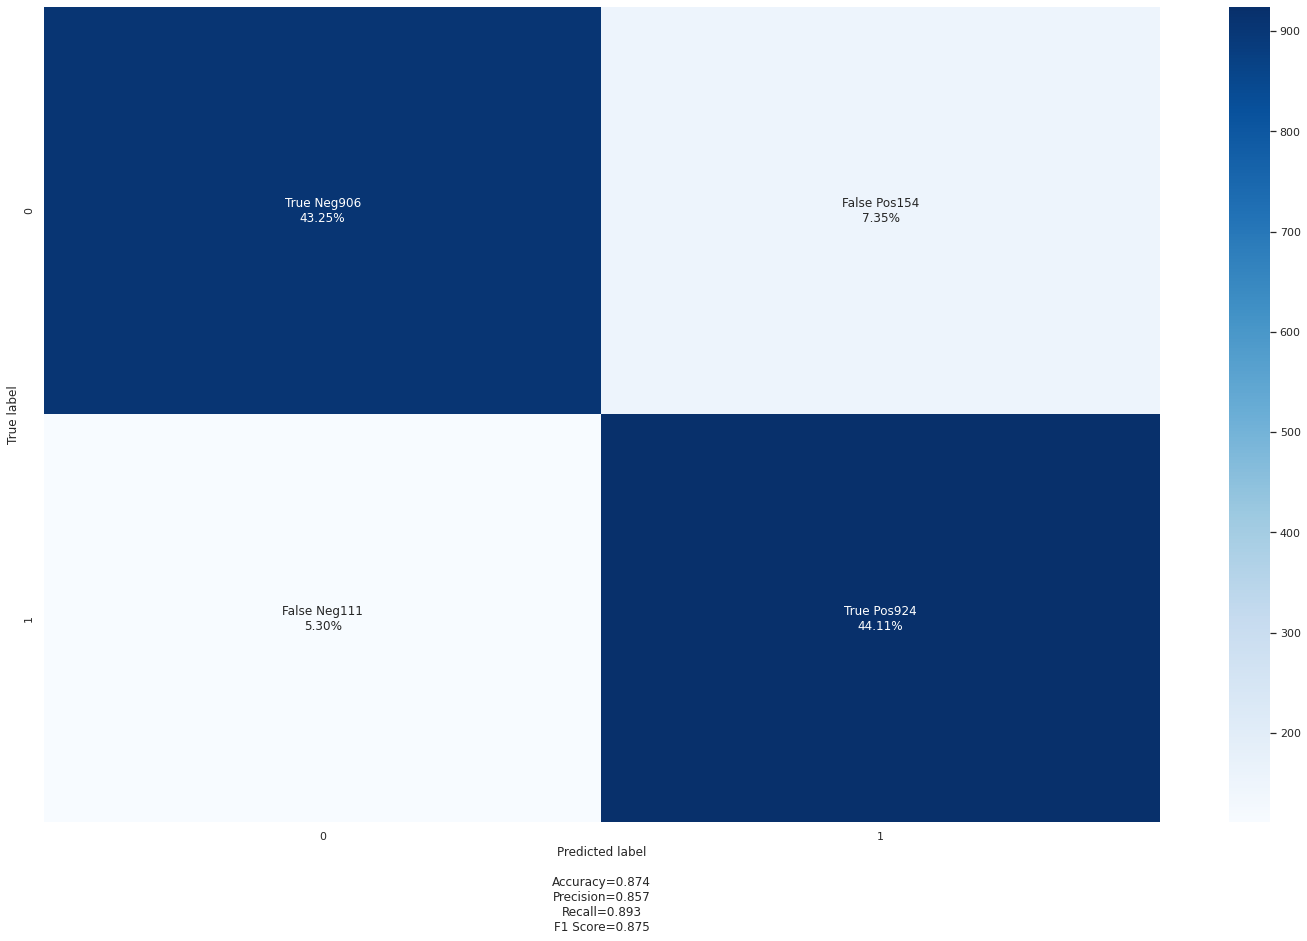

In [250]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierperceptron.predict(X_test))

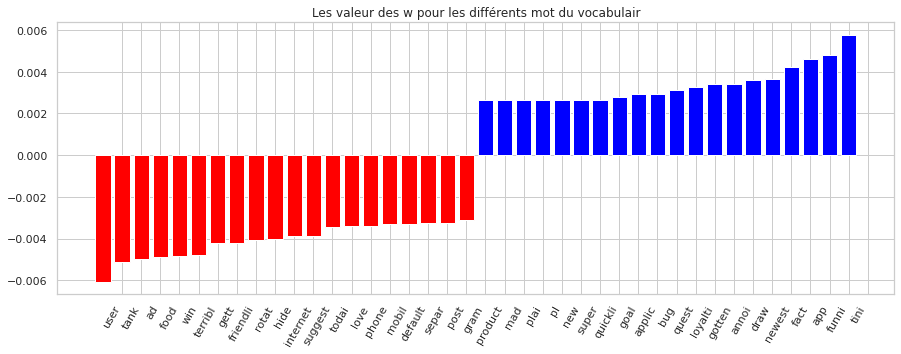

In [251]:
fig = utils.plot_coefficients(classifierperceptron.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

#### Commentaire : 
Dans la figur ci dessus on voit l'attribution des poids au différents mot du vocabulaire.
On voit que les mots positifs il leurs attribut des poids + et les mors negatifs il leurs attribut des poids - 

### ClassifierPerceptronBiais

In [252]:
classifierperceptronbiais = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    learning_rate=1, 
    batch_size=16, 
    epochs=10
)


In [253]:
tic = timeit.default_timer() # heure de départ
classifierperceptronbiais.train(X_train, y_train)

In [254]:
classifierperceptronbiais.accuracy(X_test, y_test)

0.8892601431980907

In [255]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.58557 secondes


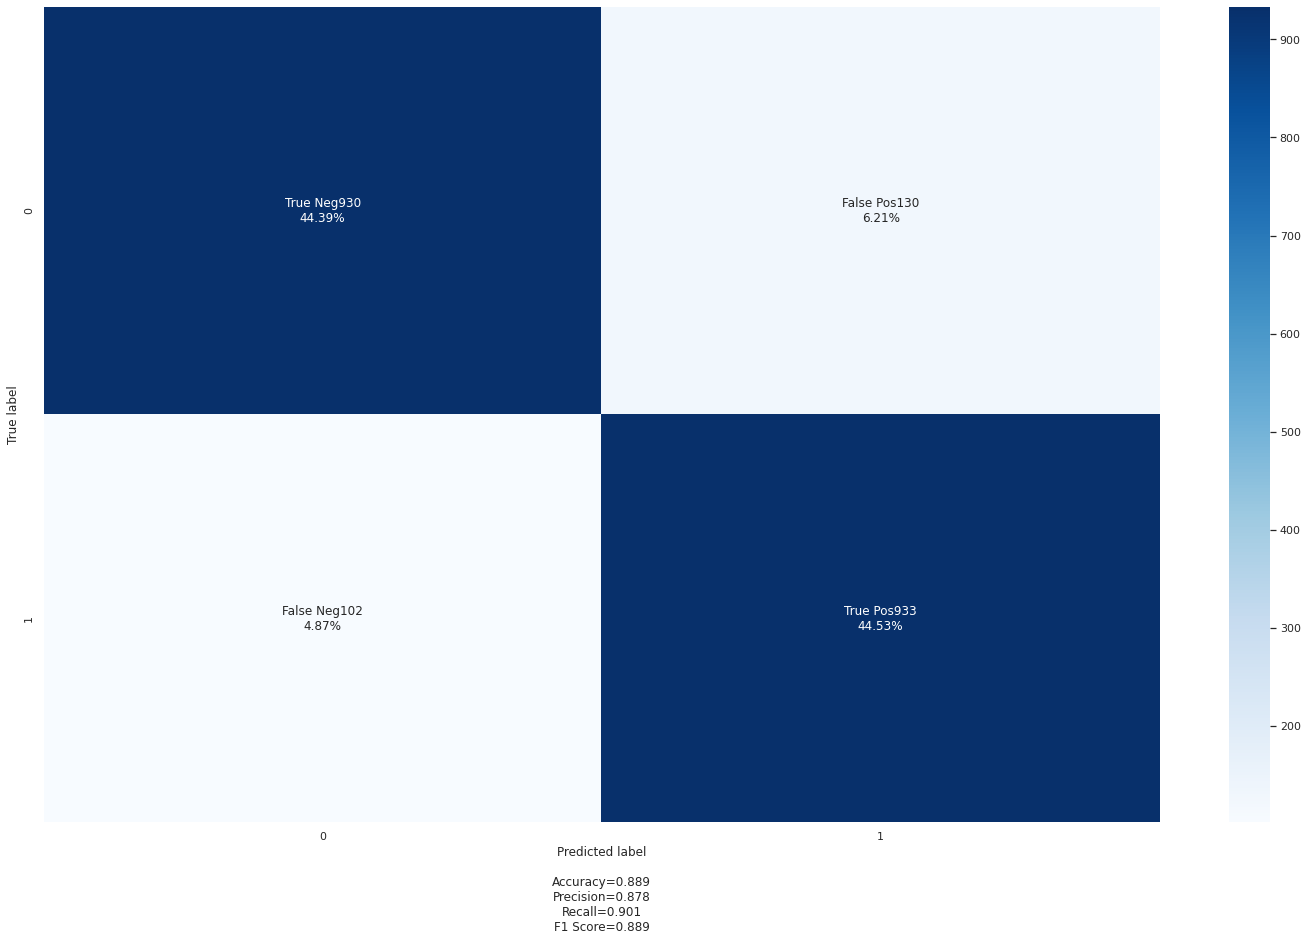

In [256]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierperceptronbiais.predict(X_test))

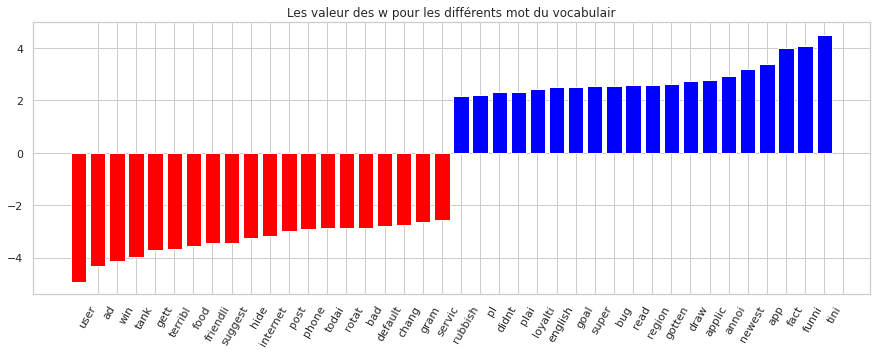

In [257]:
fig = utils.plot_coefficients(classifierperceptronbiais.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

### ClassifierADALINE

In [258]:
classifieradaline = ClassifierADALINE(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-1, 
    batch_size=16, 
    epochs=10
)

In [259]:
tic = timeit.default_timer() # heure de départ
classifieradaline.train(X_train, y_train)

In [260]:
classifieradaline.accuracy(X_test, y_test)

0.8682577565632458

In [261]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.89310 secondes


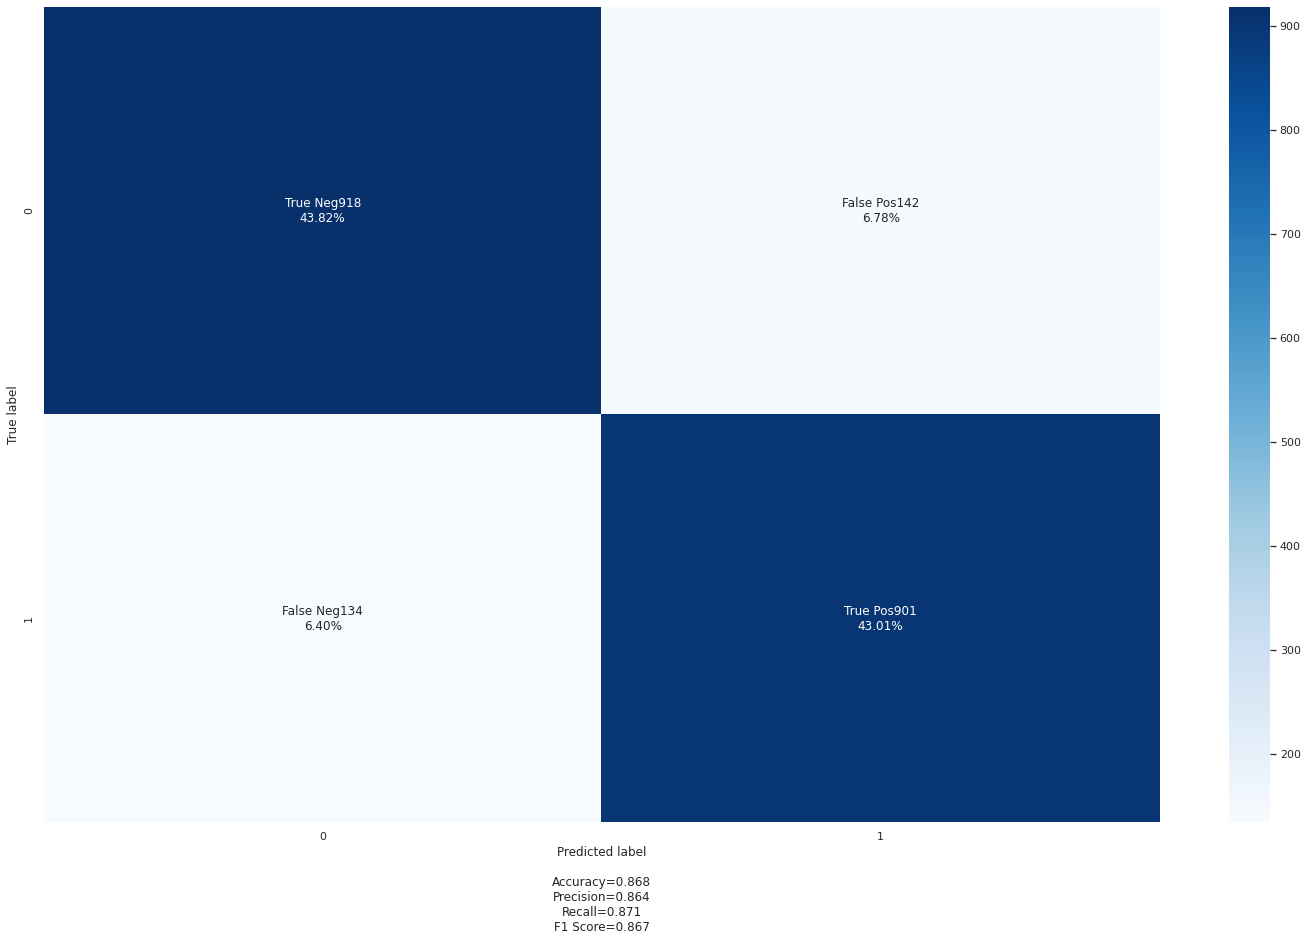

In [262]:
cf_matrix = evaluation.matrix_confusion(y_test, classifieradaline.predict(X_test))

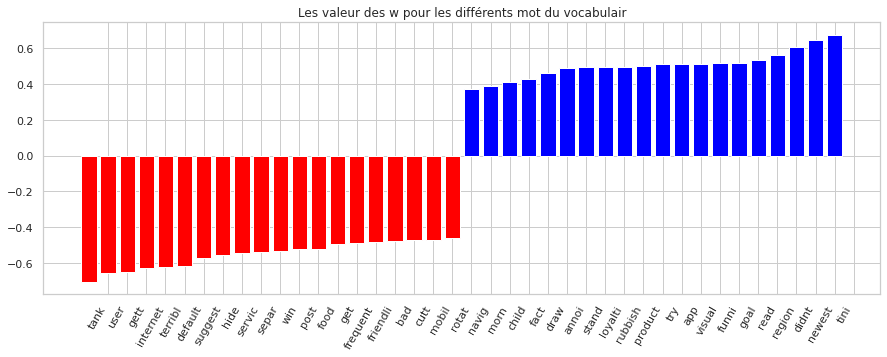

In [263]:
fig = utils.plot_coefficients(classifieradaline.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

### ClassifierPerceptronKernel With kernel

In [264]:
classifieradalinekernel = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    kernel="bias",
    learning_rate=1, 
    batch_size=64, 
    epochs=10
)

tic = timeit.default_timer() # heure de départ
classifieradalinekernel.train(X_train, y_train)

In [265]:
classifieradalinekernel.accuracy(X_test, y_test)

0.8964200477326969

In [266]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.71664 secondes


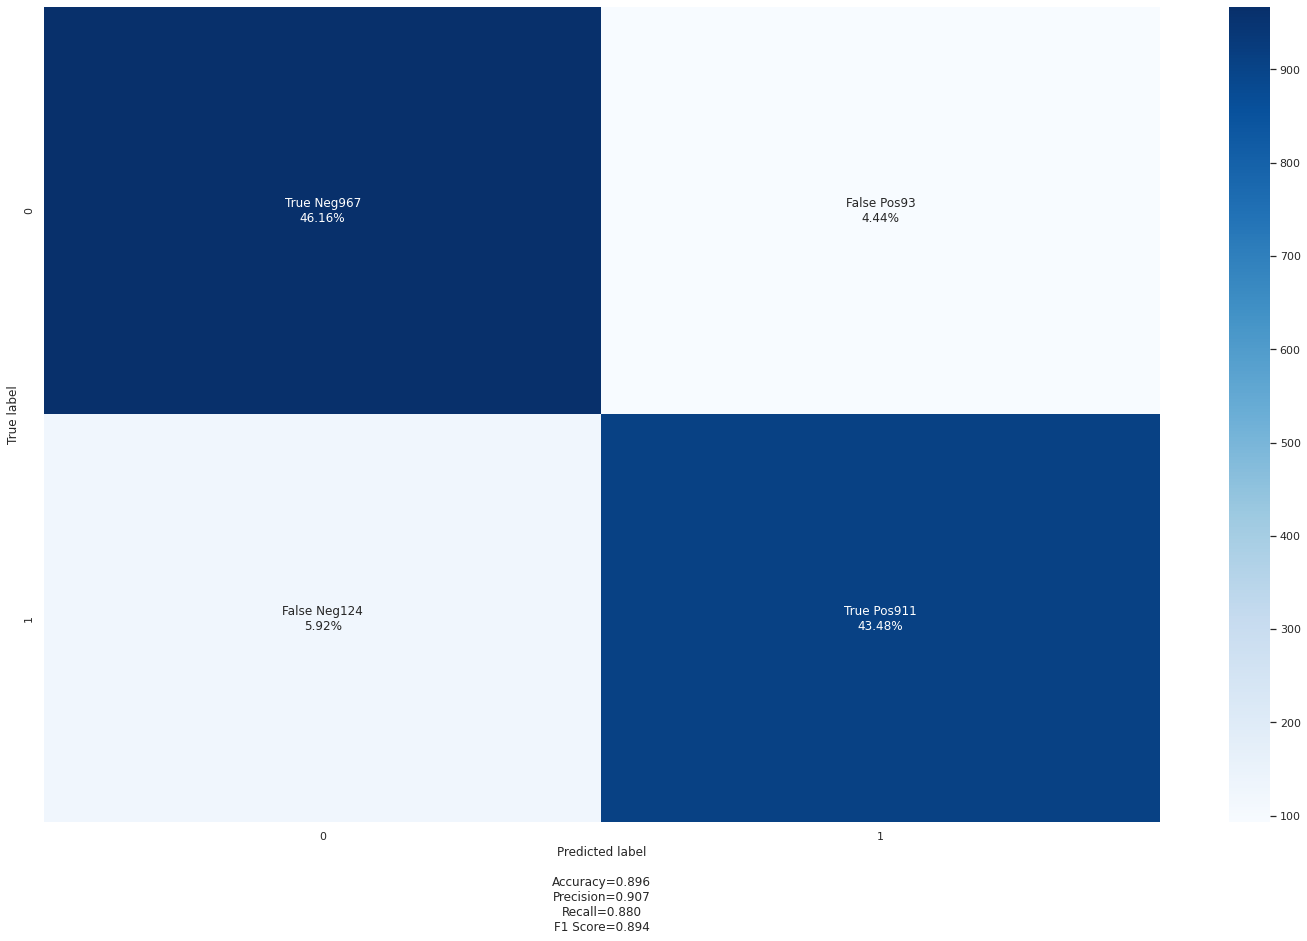

In [267]:
cf_matrix = evaluation.matrix_confusion(y_test, classifieradalinekernel.predict(X_test))

## Classification binaire avec TFIDFVectorizer

In [268]:
train_bin = train[train.Sentiment != "Neutral"] 
test_bin = test[test.Sentiment != "Neutral"]

print(train_bin.Sentiment.unique())
# On elimine les mots qui ont un nombre d'occurence trés faible on chosit 10 comme seuil
seuil = 10

vectorizer = TFIDFVectorizer(min_df=seuil)
X_train = vectorizer.fit_transform(train_bin.Review)
X_test = vectorizer.transform(test_bin.Review)

target2id = {
    "Negative":-1,
    "Positive":1
}

y_train = train_bin.Sentiment.apply(lambda x: target2id[x]).values
y_test = test_bin.Sentiment.apply(lambda x: target2id[x]).values

print(f"En eliminant tous les mots qui ont un nombre d'occurence inferieur à {seuil} on obtient un vocabulaire contenant {len(vectorizer.vocabulary)} mots.")

['Negative' 'Positive']


100%|██████████| 2095/2095 [00:00<00:00, 55678.84it/s]

En eliminant tous les mots qui ont un nombre d'occurence inferieur à 10 on obtient un vocabulaire contenant 1575 mots.


### ClassifierLineaireRandom

In [269]:
classifierlineairerandom = ClassifierLineaireRandom(X_train.shape[1])

In [270]:
tic = timeit.default_timer() # heure de départ
classifierlineairerandom.train(X_train, y_train)
classifierlineairerandom.accuracy(X_test, y_test)

0.520763723150358

In [271]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.02628 secondes


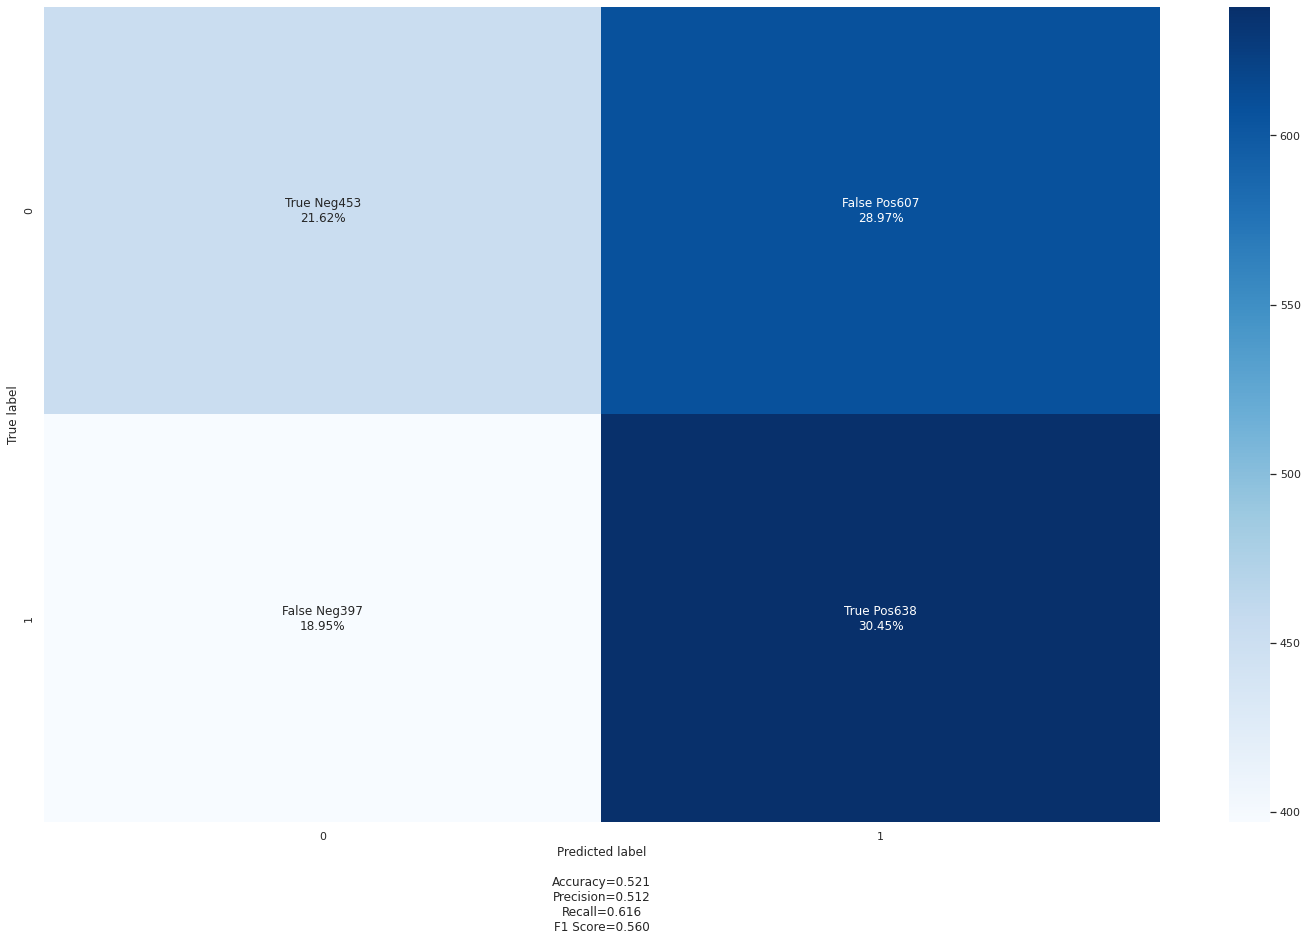

In [272]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierlineairerandom.predict(X_test))

### ClassifierKNN

In [273]:
classifierknn = ClassifierKNN(X_train.shape[1], 5) # avec k =5
tic = timeit.default_timer() # heure de départ
classifierknn = ClassifierKNN(X_train.shape[1], 5)
classifierknn.train(X_train, y_train)

In [274]:
classifierknn.accuracy(X_test, y_test)

0.711217183770883

In [275]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 2.69005 secondes


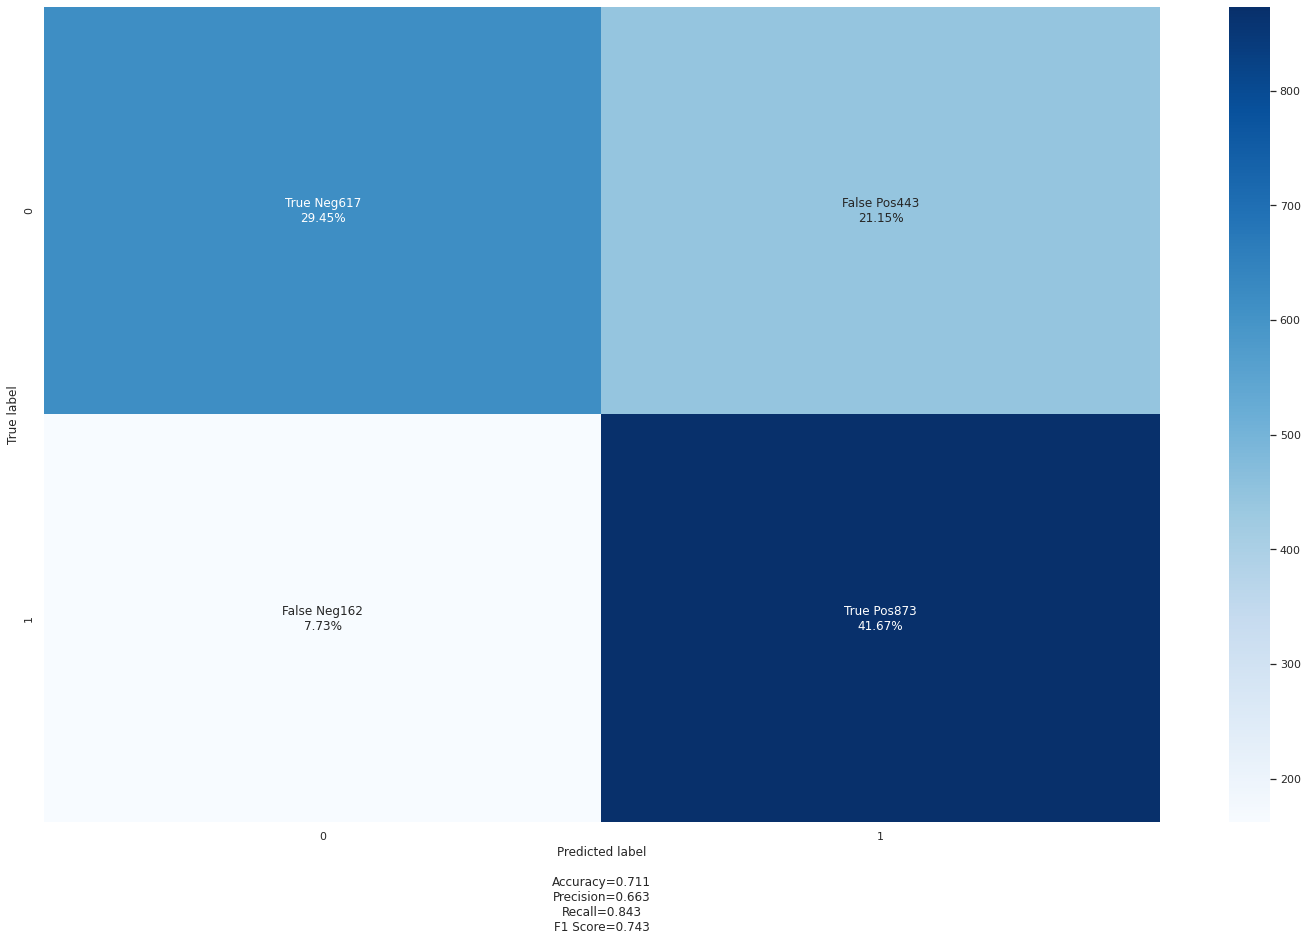

In [276]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierknn.predict(X_test))

### ClassifierPerceptron

In [277]:
classifierperceptron = ClassifierPerceptron(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-2, 
    batch_size=64, 
    epochs=10
)

In [278]:
tic = timeit.default_timer() # heure de départ
classifierperceptron.train(X_train, y_train)

In [279]:
classifierperceptron.accuracy(X_test, y_test)

0.8840095465393795

In [280]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.54688 secondes


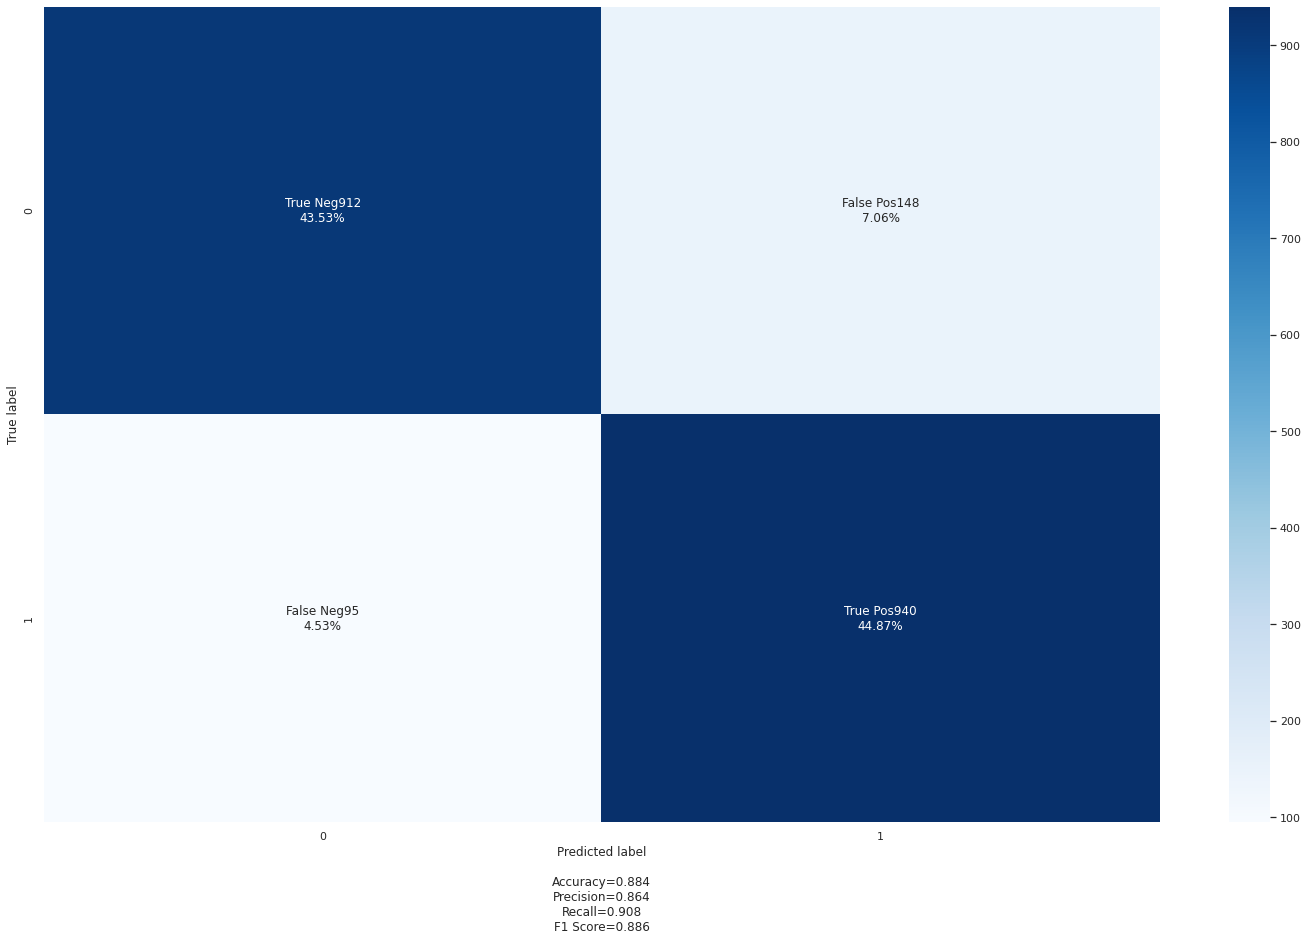

In [281]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierperceptron.predict(X_test))

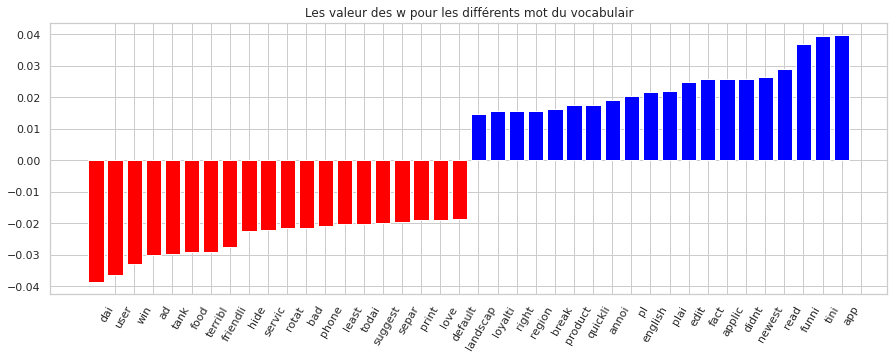

In [282]:
fig = utils.plot_coefficients(classifierperceptron.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

### ClassifierPerceptronBiais

In [283]:
classifierperceptronbiais = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    learning_rate=1, 
    batch_size=16, 
    epochs=10
)
tic = timeit.default_timer() # heure de départ
classifierperceptronbiais.train(X_train, y_train)

In [284]:
classifierperceptronbiais.accuracy(X_test, y_test)

0.867780429594272

In [285]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 1.72928 secondes


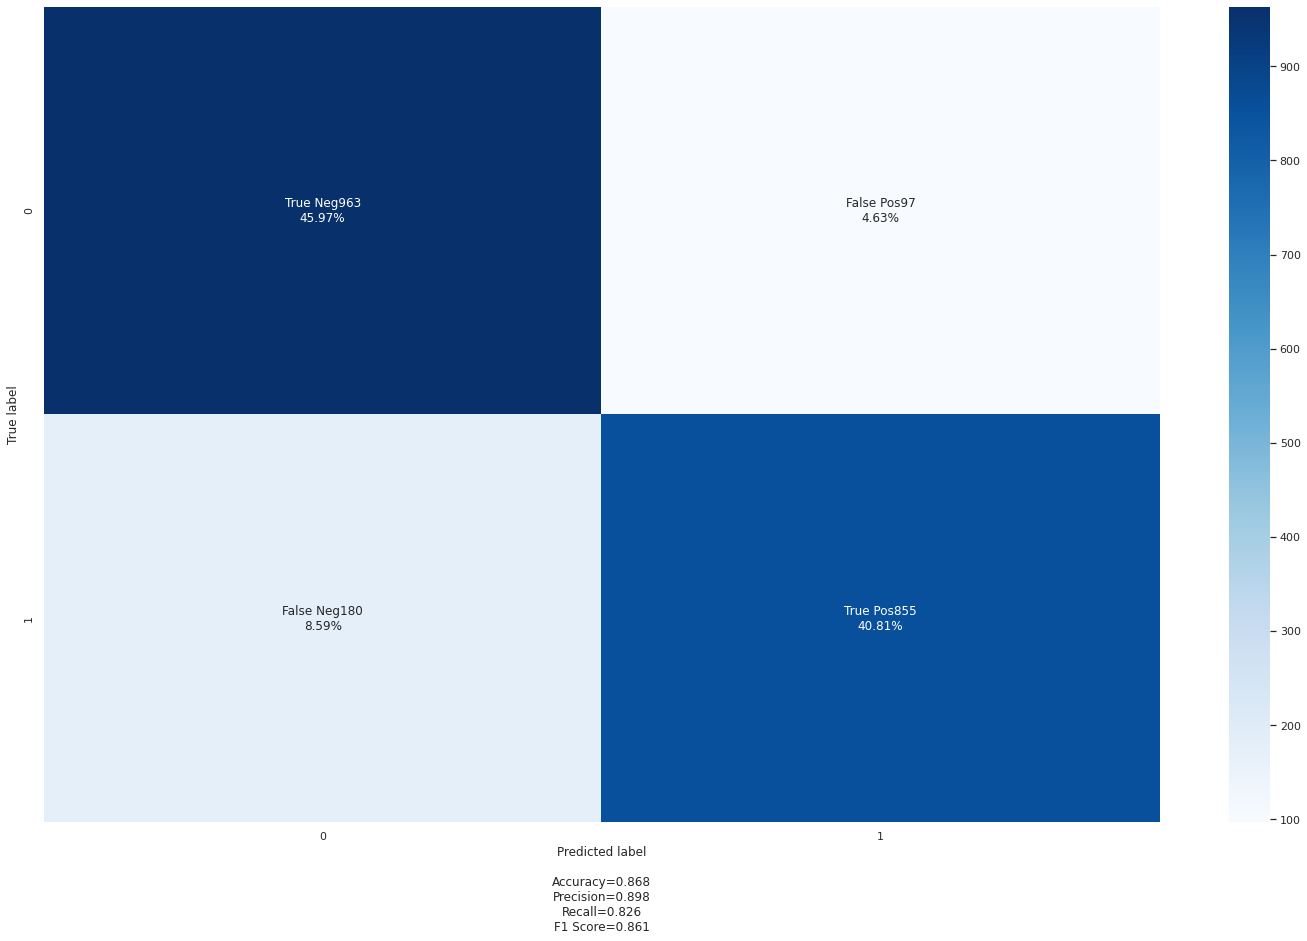

In [286]:
cf_matrix = evaluation.matrix_confusion(y_test, classifierperceptronbiais.predict(X_test))

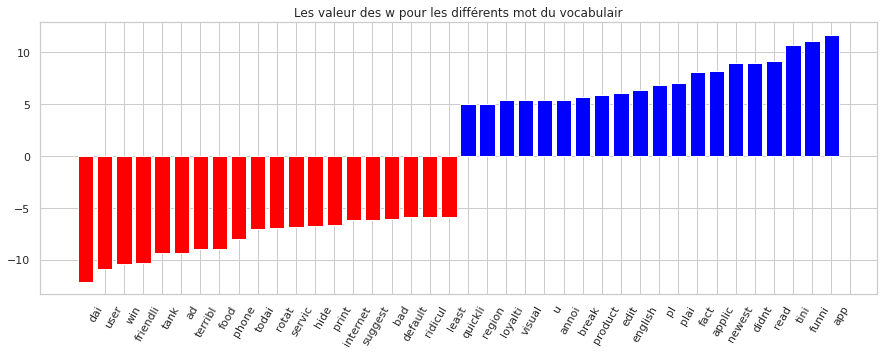

In [287]:
fig = utils.plot_coefficients(classifierperceptronbiais.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

### ClassifierADALINE

In [288]:
classifieradaline = ClassifierADALINE(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-3, 
    batch_size=32, 
    epochs=50
)

In [289]:
tic = timeit.default_timer() # heure de départ
classifieradaline.train(X_train, y_train)

In [290]:
classifieradaline.accuracy(X_test, y_test)

0.8749403341288783

In [291]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 1.16654 secondes


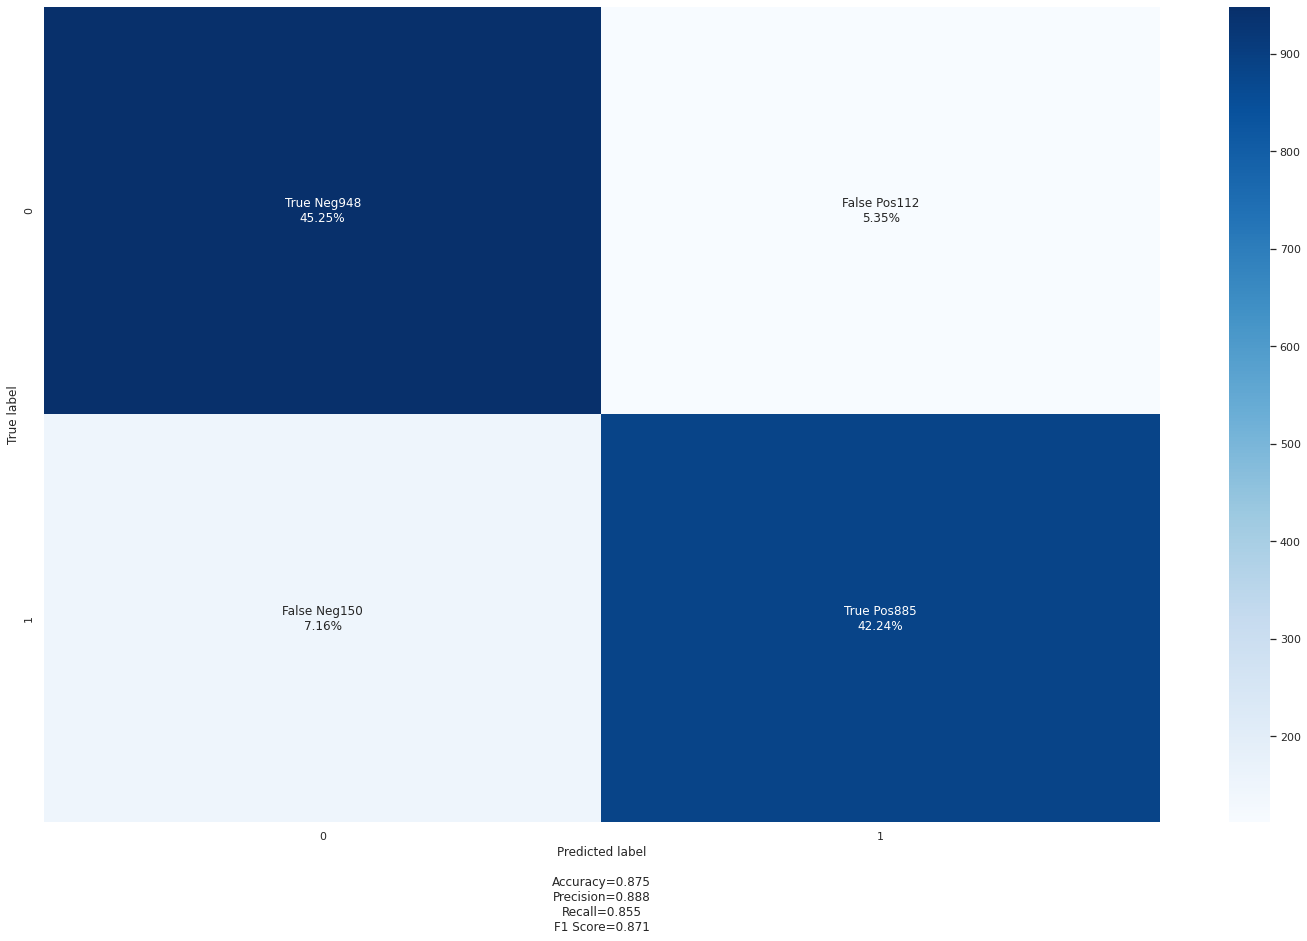

In [292]:
cf_matrix = evaluation.matrix_confusion(y_test, classifieradaline.predict(X_test))

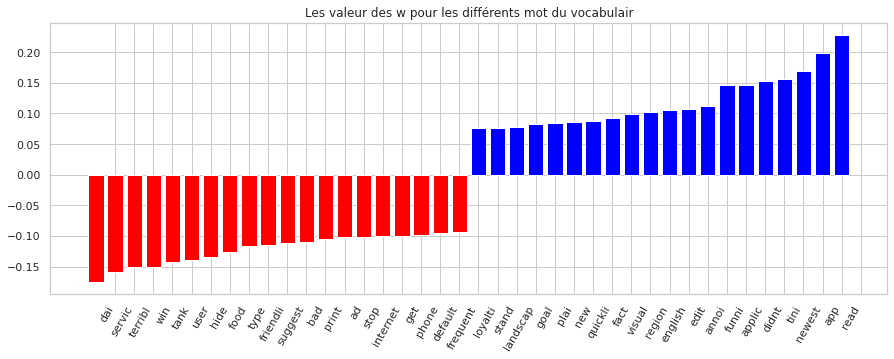

In [293]:
fig = utils.plot_coefficients(classifieradaline.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

### ClassifierPerceptronKernel With kernel

In [298]:
classifieradalinekernel = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    kernel="bias",
    learning_rate=1, 
    batch_size=64, 
    epochs=10
)
tic = timeit.default_timer() # heure de départ
classifieradalinekernel.train(X_train, y_train)

In [299]:
classifieradalinekernel.accuracy(X_test, y_test)

0.879236276849642

In [300]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 0.69618 secondes


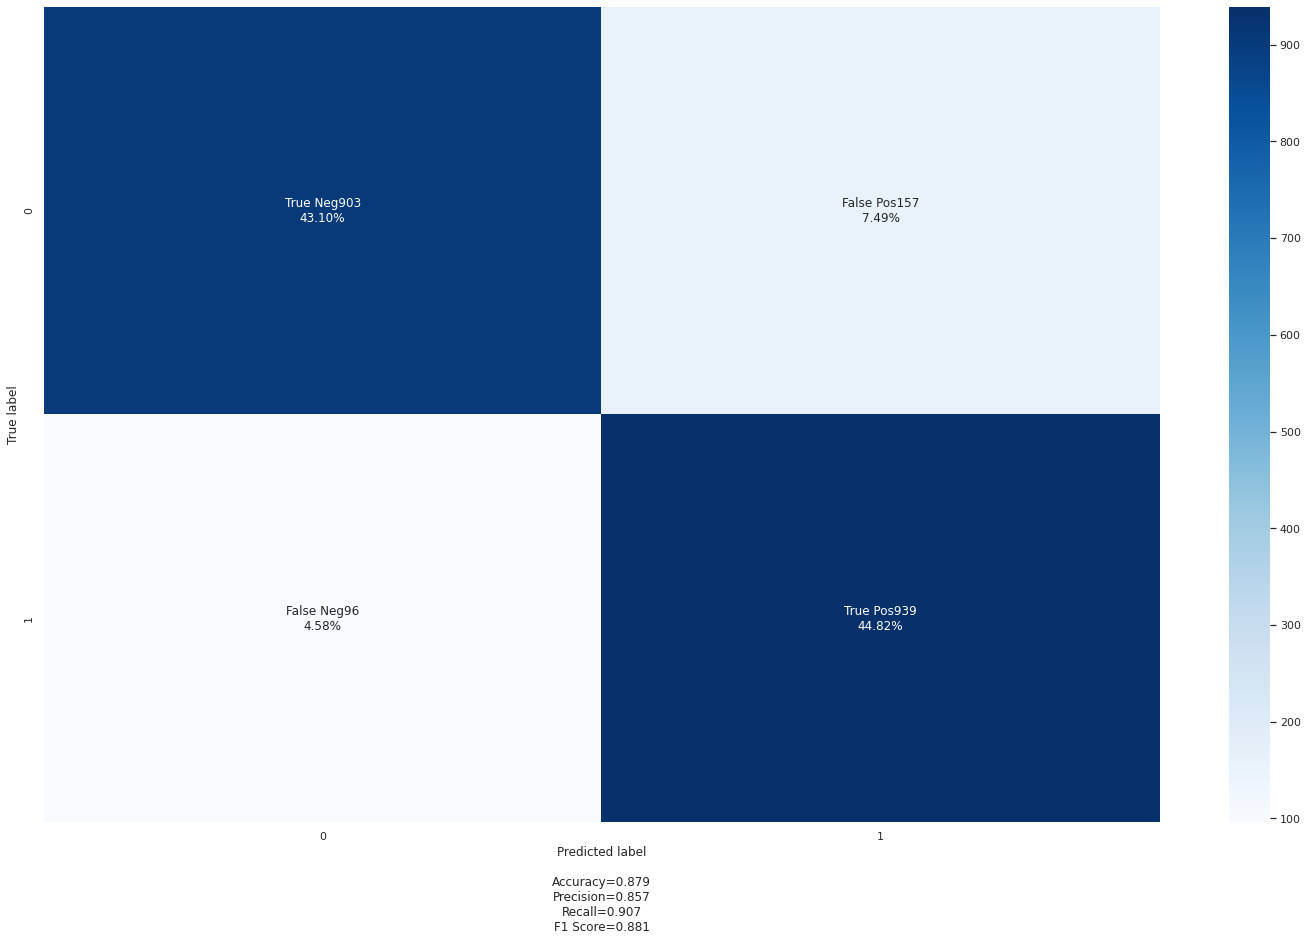

In [301]:
cf_matrix = evaluation.matrix_confusion(y_test, classifieradalinekernel.predict(X_test))

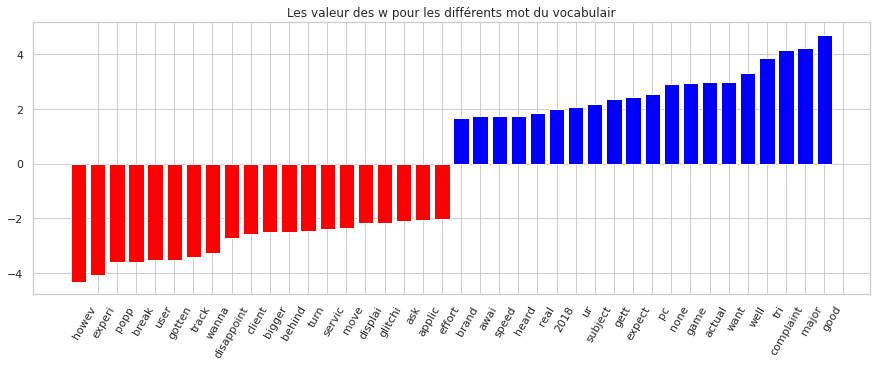

In [302]:
fig = utils.plot_coefficients(classifieradalinekernel.getW().ravel(), list(vectorizer.vocabulary.keys()))
fig.show()

## MultiClassification CountVectorizer

In [303]:
#train_bin = train[train.Sentiment != "Neutral"] 
#test_bin = test[test.Sentiment != "Neutral"]

print(train.Sentiment.unique())
# On elimine les mots qui ont un nombre d'occurence trés faible on chosit 10 comme seuil
seuil = 10

vectorizer = CountVectorizer(min_df=seuil)
X_train = vectorizer.fit_transform(train.Review)
X_test = vectorizer.transform(test.Review)

multitarget2id = {
    "Negative":0,
    "Neutral":1,
    "Positive":2,
    
}

y_train = train.Sentiment.apply(lambda x: multitarget2id[x]).values
y_test = test.Sentiment.apply(lambda x: multitarget2id[x]).values

print(f"En eliminant tous les mots qui ont un nombre d'occurence inferieur à {seuil} on obtient un vocabulaire contenant {len(vectorizer.vocabulary)} mots.")

['Negative' 'Positive' 'Neutral']


100%|██████████| 3095/3095 [00:00<00:00, 114696.69it/s]

En eliminant tous les mots qui ont un nombre d'occurence inferieur à 10 on obtient un vocabulaire contenant 1761 mots.


### Multi classe avec ClassifierLineaireRandom

In [304]:
multi_classifierlineairerandom = ClassifierMultiOAA(
        classifieur= ClassifierLineaireRandom(X_train.shape[1]),
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifierlineairerandom.train(X_train, y_train)
multi_classifierlineairerandom.accuracy(X_test, y_test)

0.34248788368336025

In [305]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')



Temps mis --> 0.33496 secondes


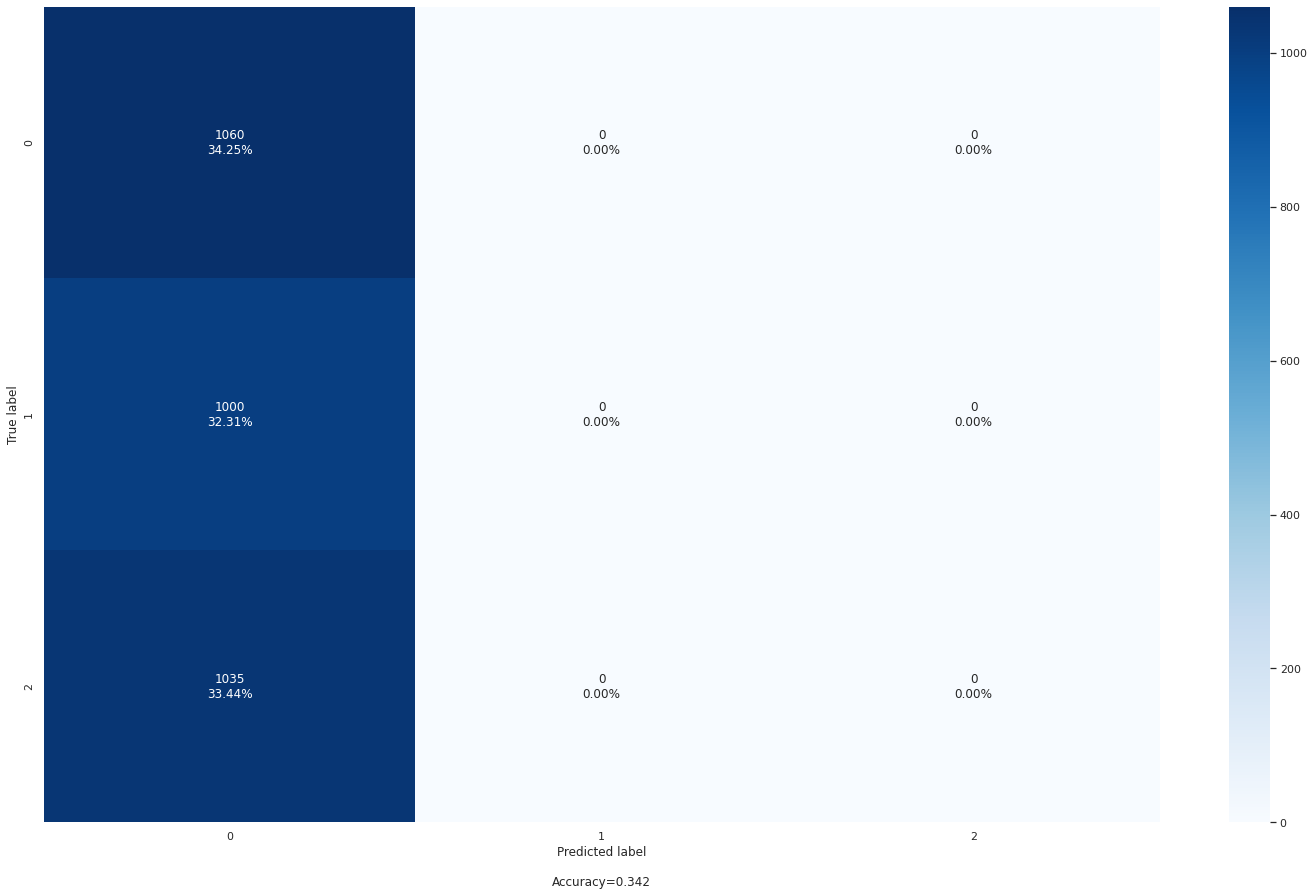

In [306]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifierlineairerandom.predict(X_test))

### Multi classe avec ClassifierKNN

In [307]:
multi_classifier_knn = ClassifierMultiOAA(
        classifieur= ClassifierKNN(X_train.shape[1], 5),
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_knn .train(X_train, y_train)
multi_classifier_knn .accuracy(X_test, y_test)


0.5935379644588046

In [308]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 11.66573 secondes


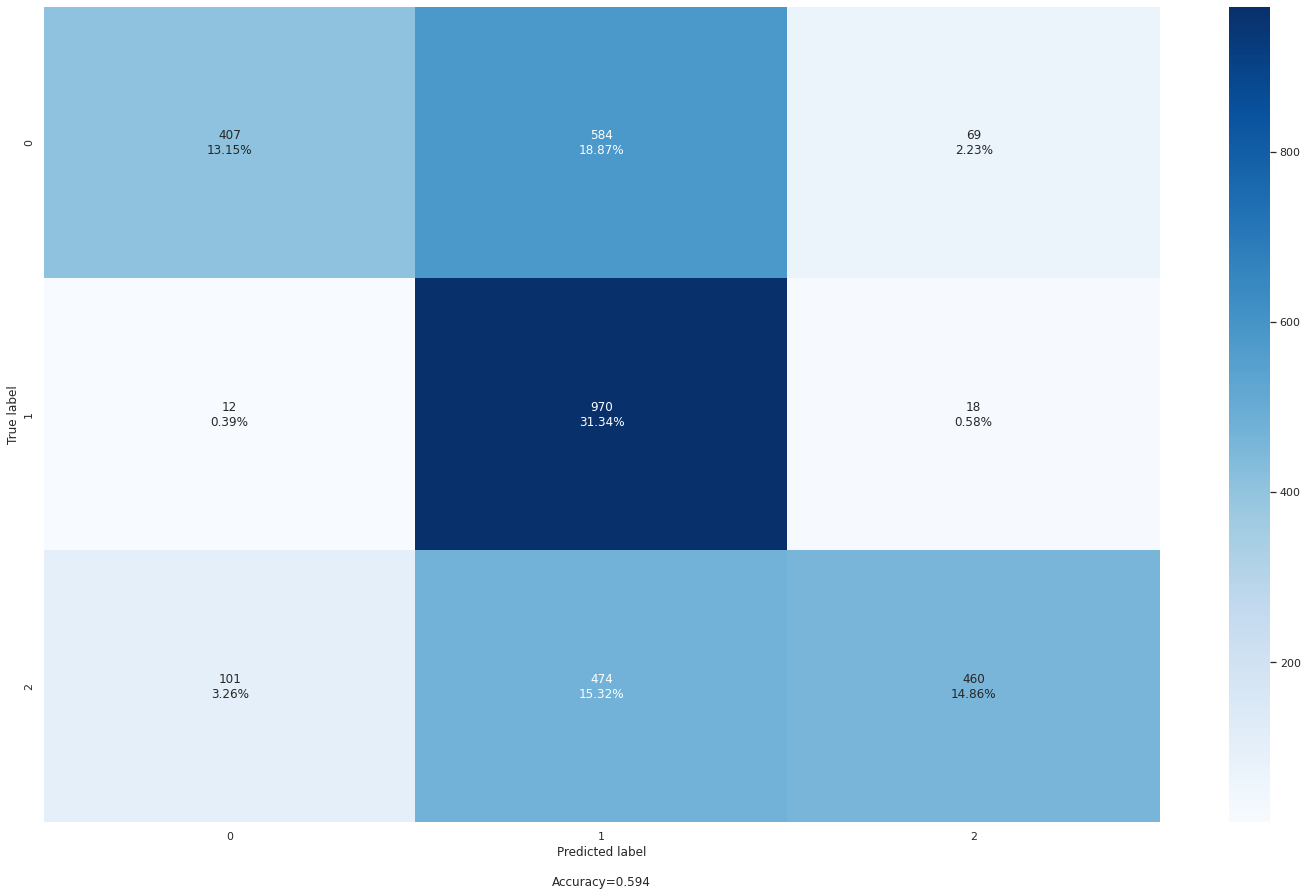

In [309]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_knn.predict(X_test))

### Multi classe avec ClassifierPerceptron

In [310]:
classifierperceptron_1= ClassifierPerceptron(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-2, 
    batch_size=64,  
    epochs=10 
) 

multi_classifier_perceptron = ClassifierMultiOAA(
        classifieur= classifierperceptron_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron .train(X_train, y_train)
multi_classifier_perceptron .accuracy(X_test, y_test)

0.8019386106623586

In [311]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 1.28796 secondes


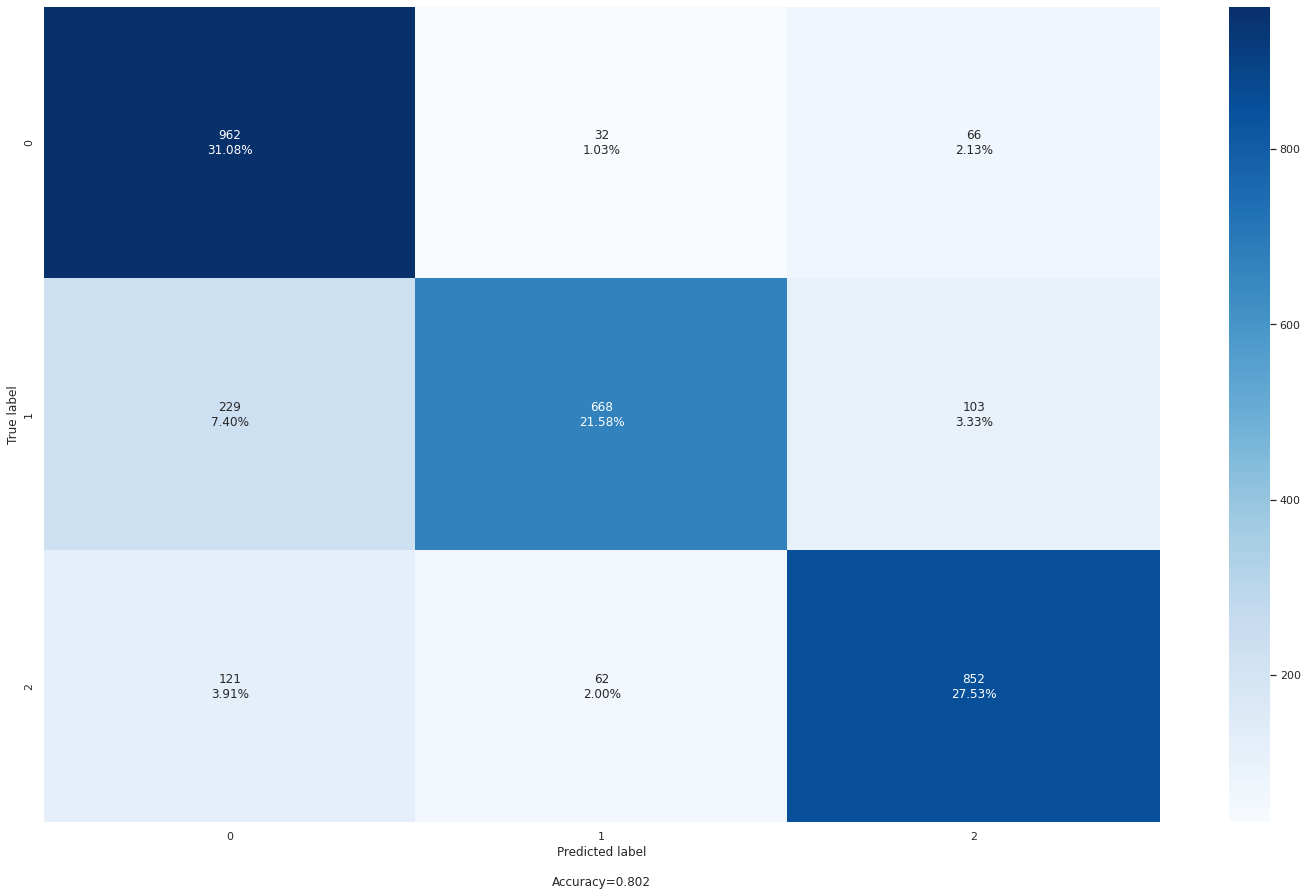

In [312]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron.predict(X_test))

<AxesSubplot:>

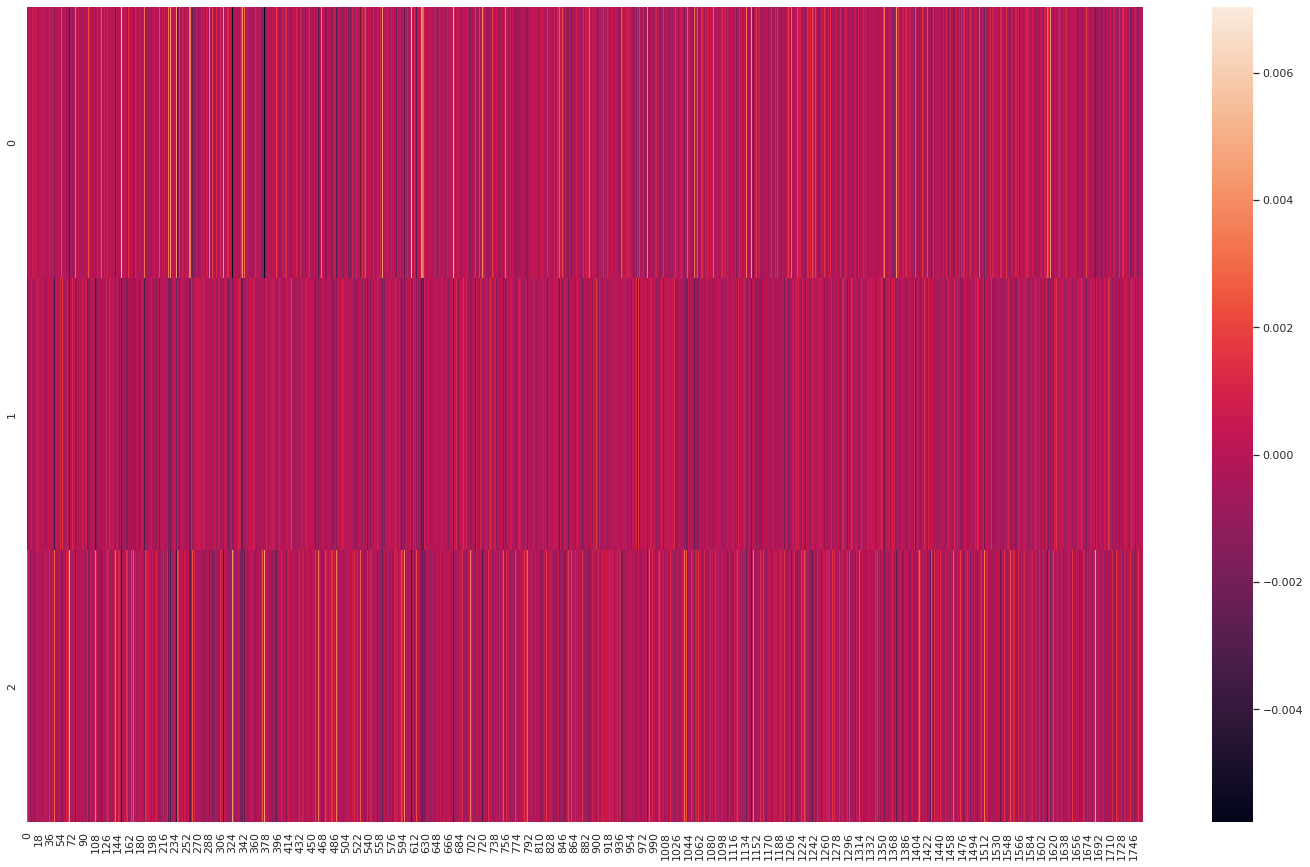

In [313]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron.liste_classifieurs.values()])
sns.heatmap(w)

#### Commentair: 
Dans la figur ci dessus on affiche les différents w dionnés par le classifier pour les différents classs 

### Multi classe avec ClassifierPerceptronBians

In [314]:
classifierperceptronbiais_1 = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    learning_rate=1, 
    batch_size=16, 
    epochs=10
)

multi_classifier_perceptron_biais= ClassifierMultiOAA(
        classifieur= classifierperceptronbiais_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron_biais .train(X_train, y_train)
multi_classifier_perceptron_biais .accuracy(X_test, y_test)

0.8478190630048466

In [315]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 2.77562 secondes


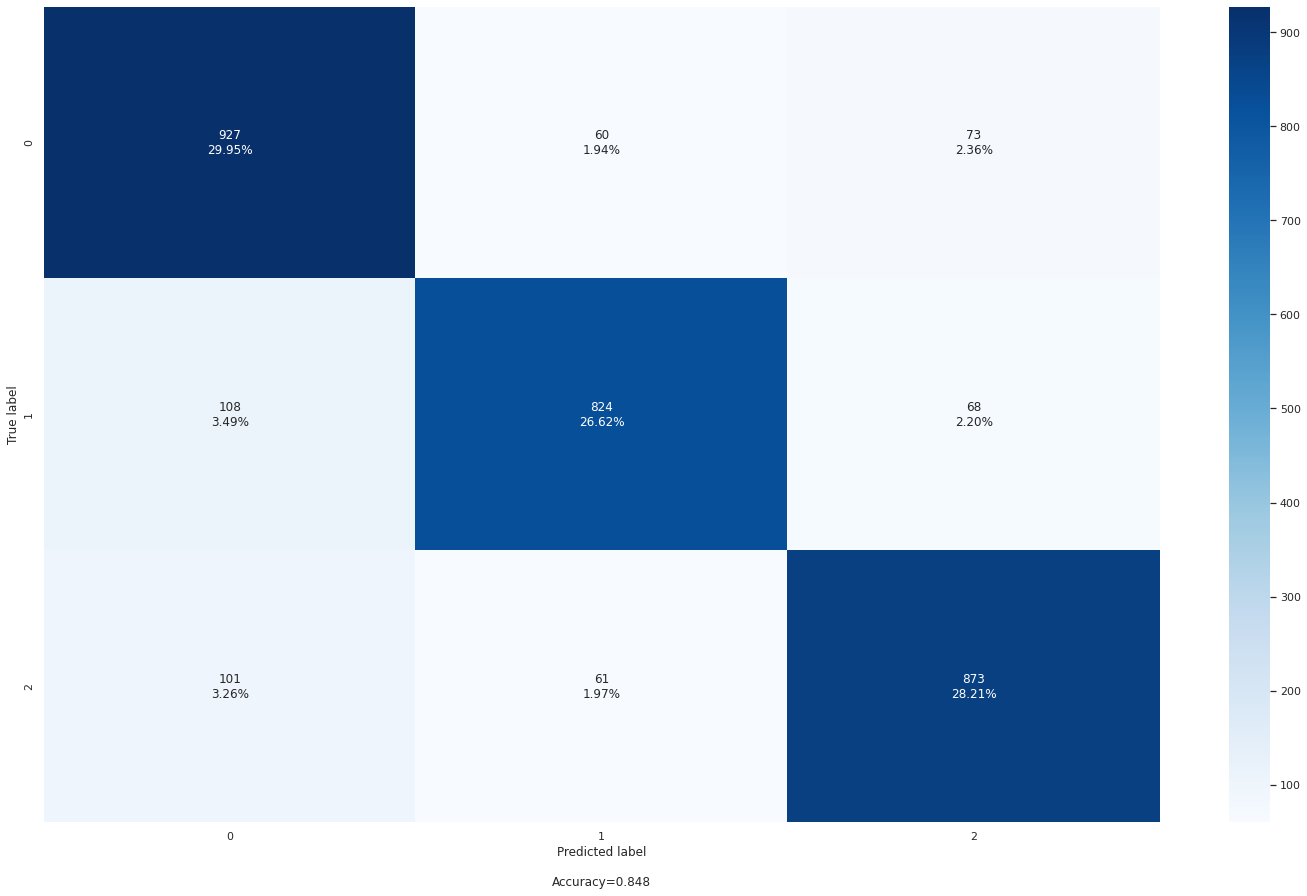

In [316]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron_biais.predict(X_test))

<AxesSubplot:>

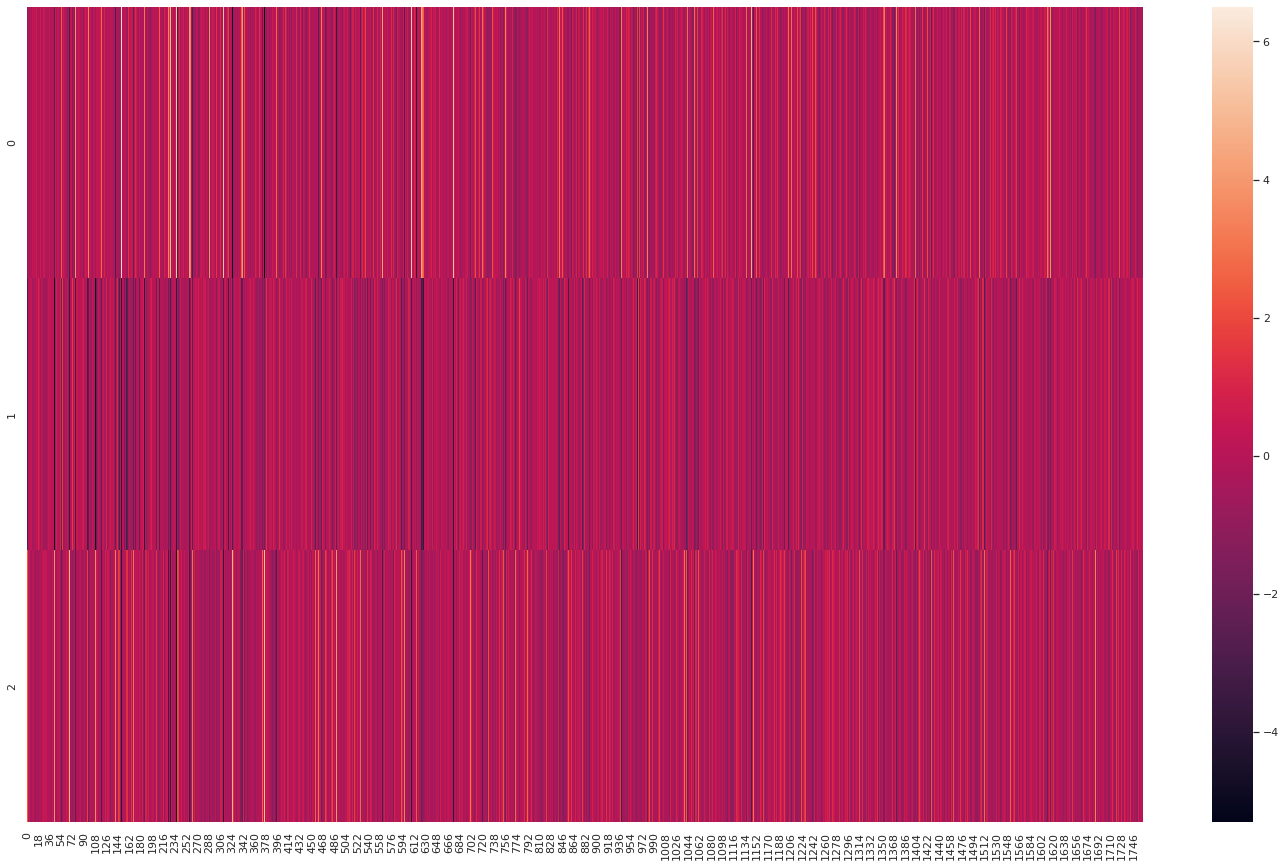

In [317]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron_biais.liste_classifieurs.values()])
sns.heatmap(w)

### Multi classe avec ClassifierADALINE

In [318]:
classifieradaline_1= ClassifierADALINE(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-1, 
    batch_size=16, 
    epochs=10
)

multi_classifier_perceptron_adaline= ClassifierMultiOAA(
        classifieur= classifieradaline_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron_adaline .train(X_train, y_train)
multi_classifier_perceptron_adaline .accuracy(X_test, y_test)

0.7835218093699515

In [319]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 1.70740 secondes


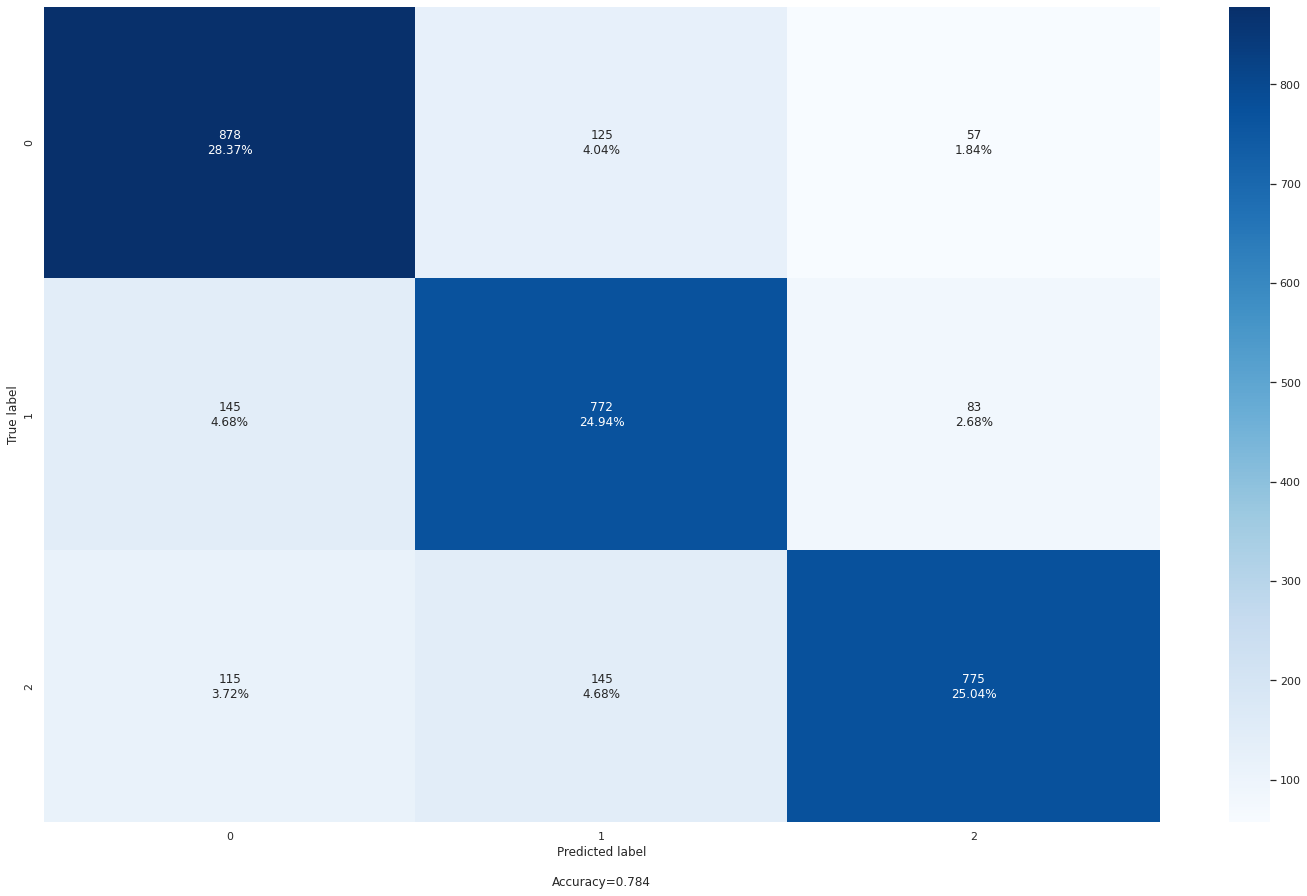

In [320]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron_adaline.predict(X_test))

<AxesSubplot:>

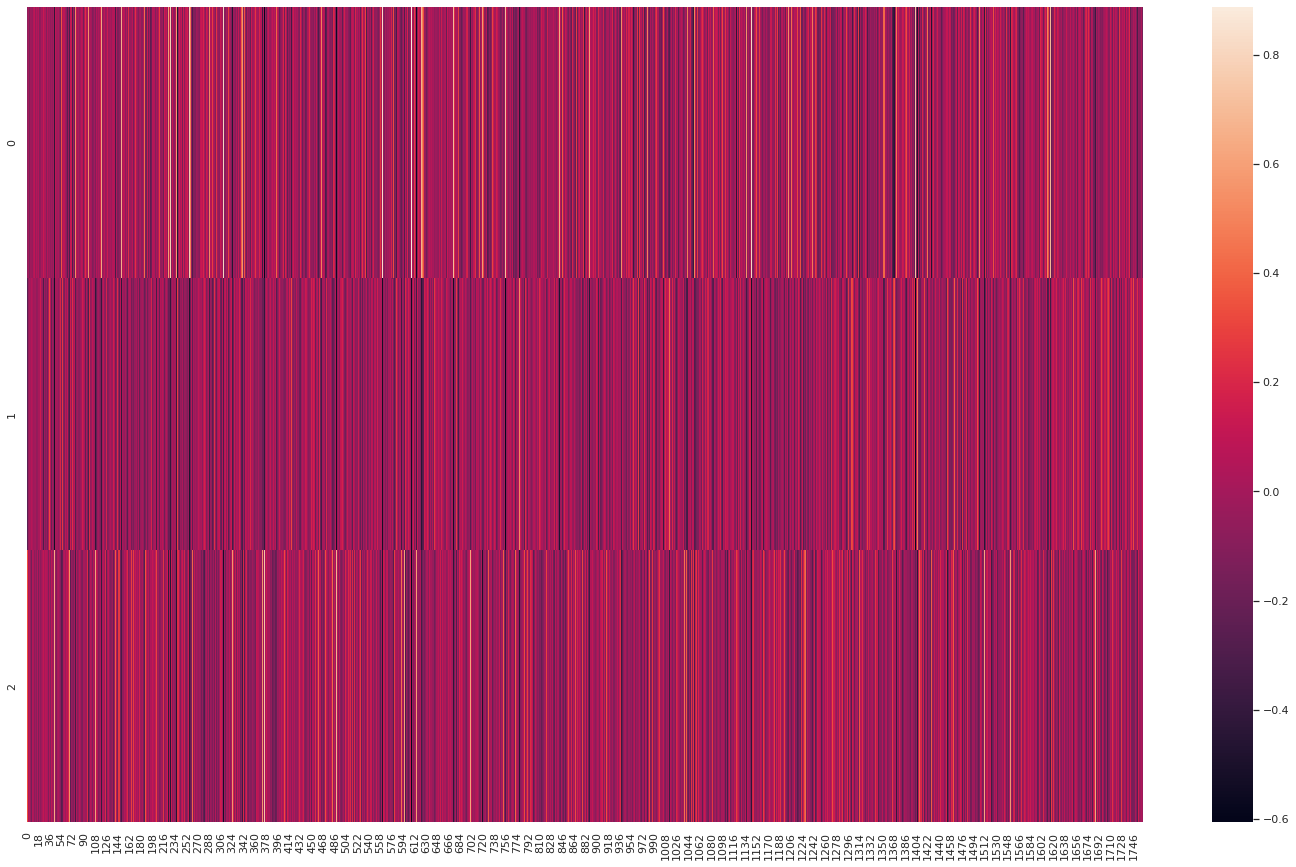

In [321]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron_adaline.liste_classifieurs.values()])
sns.heatmap(w)

# MultiClassification TFIDFVectorizer

In [322]:

print(train.Sentiment.unique())
# On elimine les mots qui ont un nombre d'occurence trés faible on chosit 10 comme seuil
seuil = 10

vectorizer = TFIDFVectorizer(min_df=seuil)
X_train = vectorizer.fit_transform(train.Review)
X_test = vectorizer.transform(test.Review)

multitarget2id = {
    "Negative":0,
    "Neutral":1,
    "Positive":2,
    
}

y_train = train.Sentiment.apply(lambda x: multitarget2id[x]).values
y_test = test.Sentiment.apply(lambda x: multitarget2id[x]).values

print(f"En eliminant tous les mots qui ont un nombre d'occurence inferieur à {seuil} on obtient un vocabulaire contenant {len(vectorizer.vocabulary)} mots.")


['Negative' 'Positive' 'Neutral']


100%|██████████| 3095/3095 [00:00<00:00, 77763.96it/s]

En eliminant tous les mots qui ont un nombre d'occurence inferieur à 10 on obtient un vocabulaire contenant 1761 mots.


### Multi classe avec Random

In [323]:
multi_classifierlineairerandom = ClassifierMultiOAA(
        classifieur= ClassifierLineaireRandom(X_train.shape[1]),
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifierlineairerandom.train(X_train, y_train)
multi_classifierlineairerandom.accuracy(X_test, y_test)

0.34248788368336025


Temps mis --> 0.33740 secondes


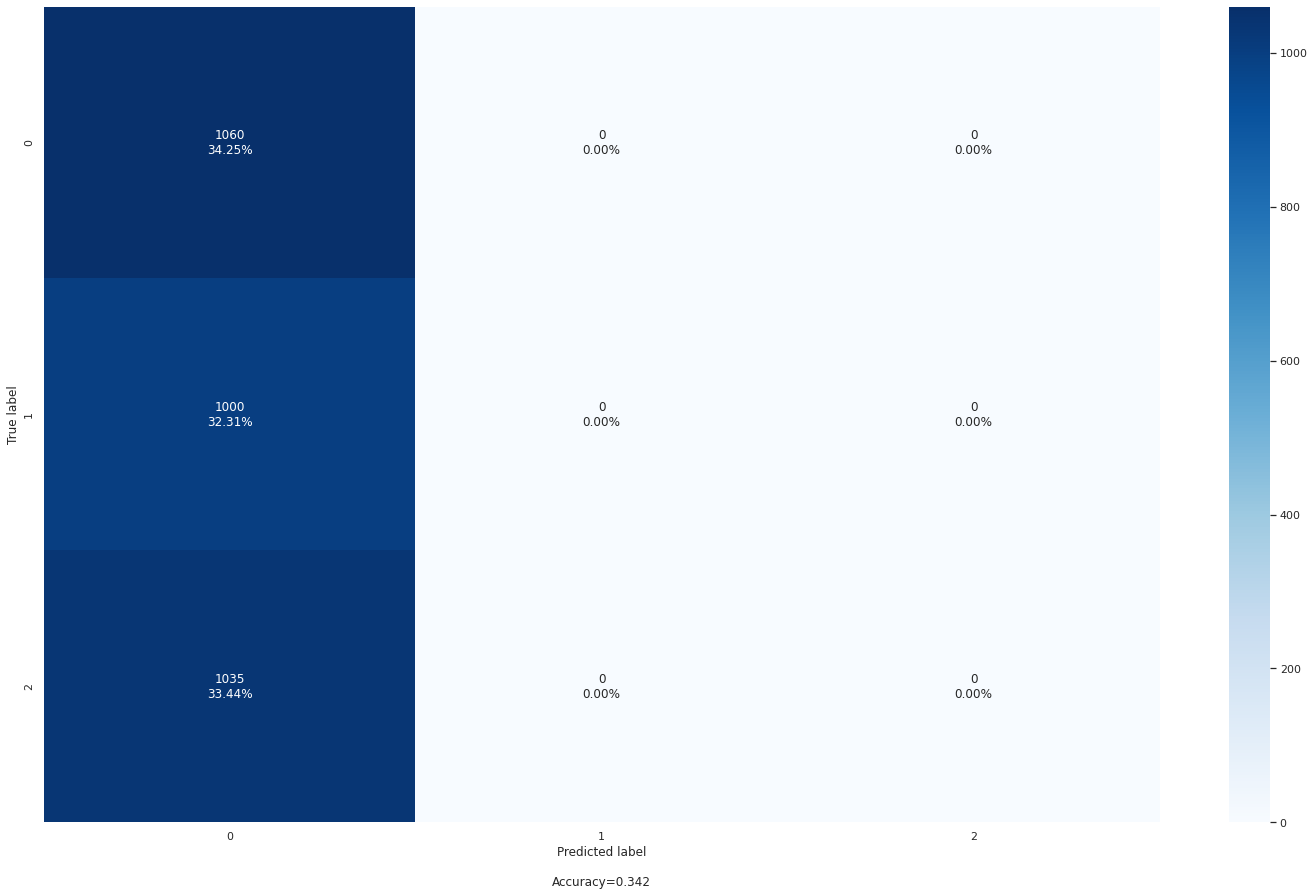

In [324]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifierlineairerandom.predict(X_test))

### Multi classe avec KNN

In [325]:
multi_classifier_knn = ClassifierMultiOAA(
        classifieur= ClassifierKNN(X_train.shape[1], 5),
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_knn .train(X_train, y_train)
multi_classifier_knn .accuracy(X_test, y_test)


0.6109854604200323

In [326]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')


Temps mis --> 15.32151 secondes


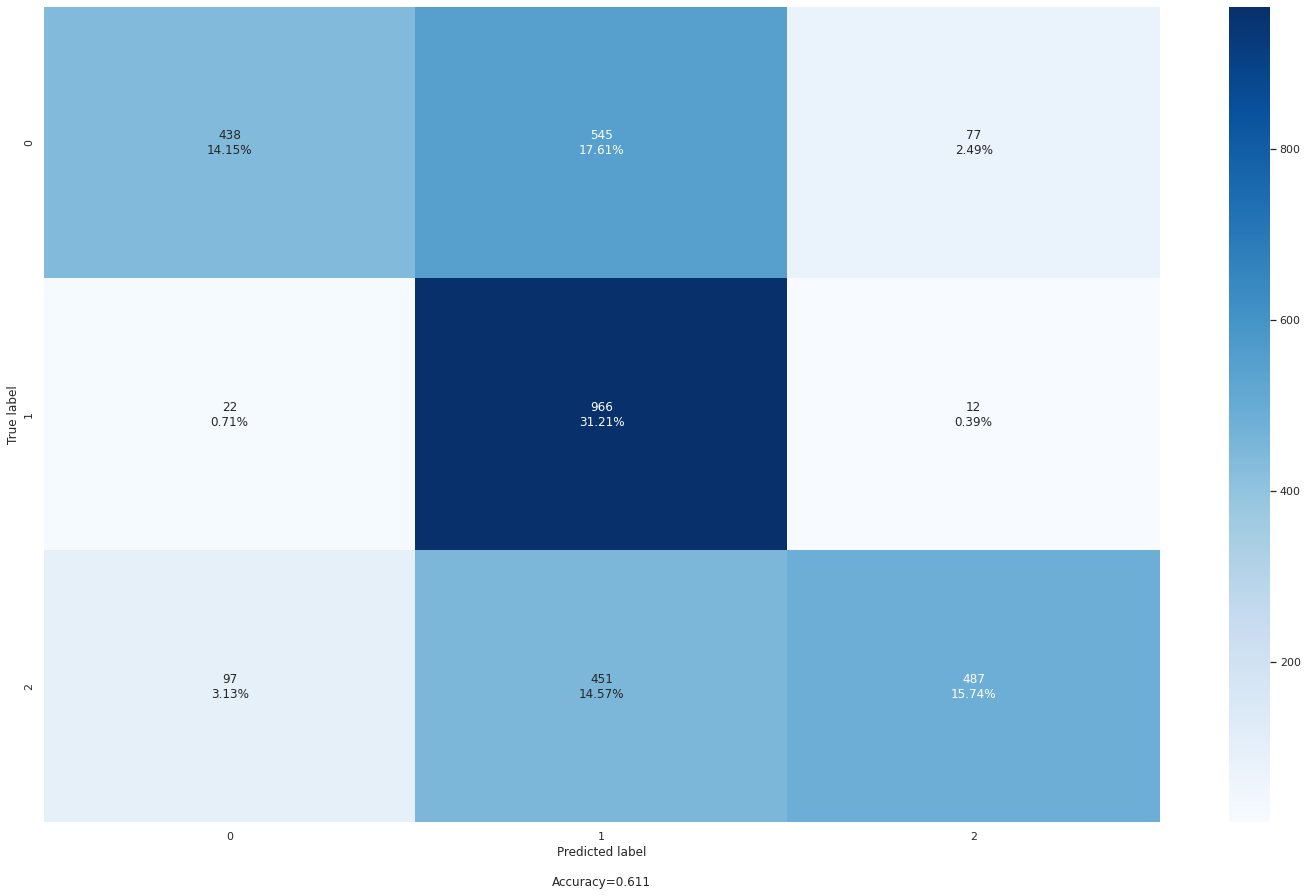

In [327]:
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_knn.predict(X_test))

### Multi classe avec Perceptron 

In [328]:
classifierperceptron_1= ClassifierPerceptron(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-2, 
    batch_size=64,  
    epochs=10 
) 

multi_classifier_perceptron = ClassifierMultiOAA(
        classifieur= classifierperceptron_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron .train(X_train, y_train)
multi_classifier_perceptron .accuracy(X_test, y_test)


0.8119547657512116


Temps mis --> 1.51710 secondes


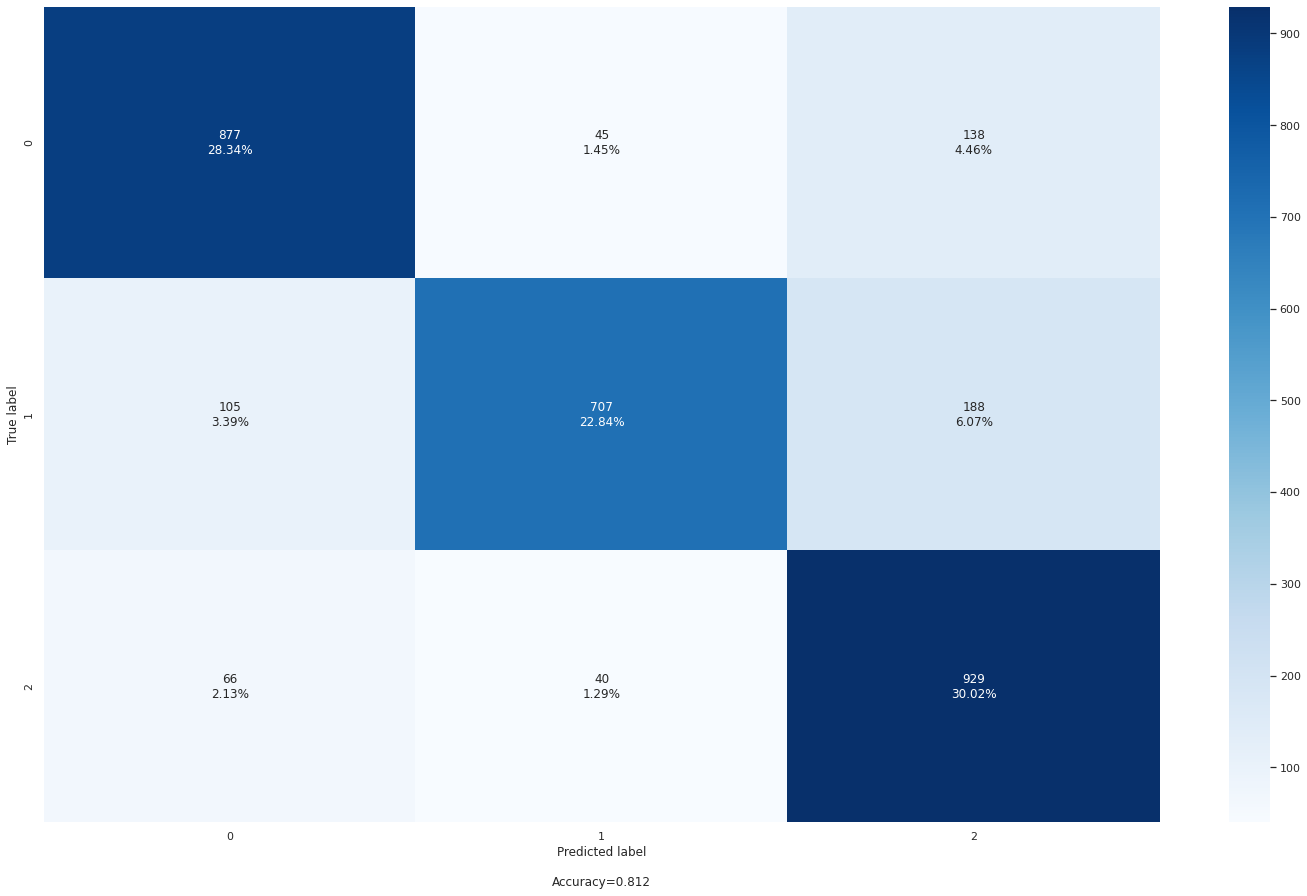

In [329]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron.predict(X_test))

<AxesSubplot:>

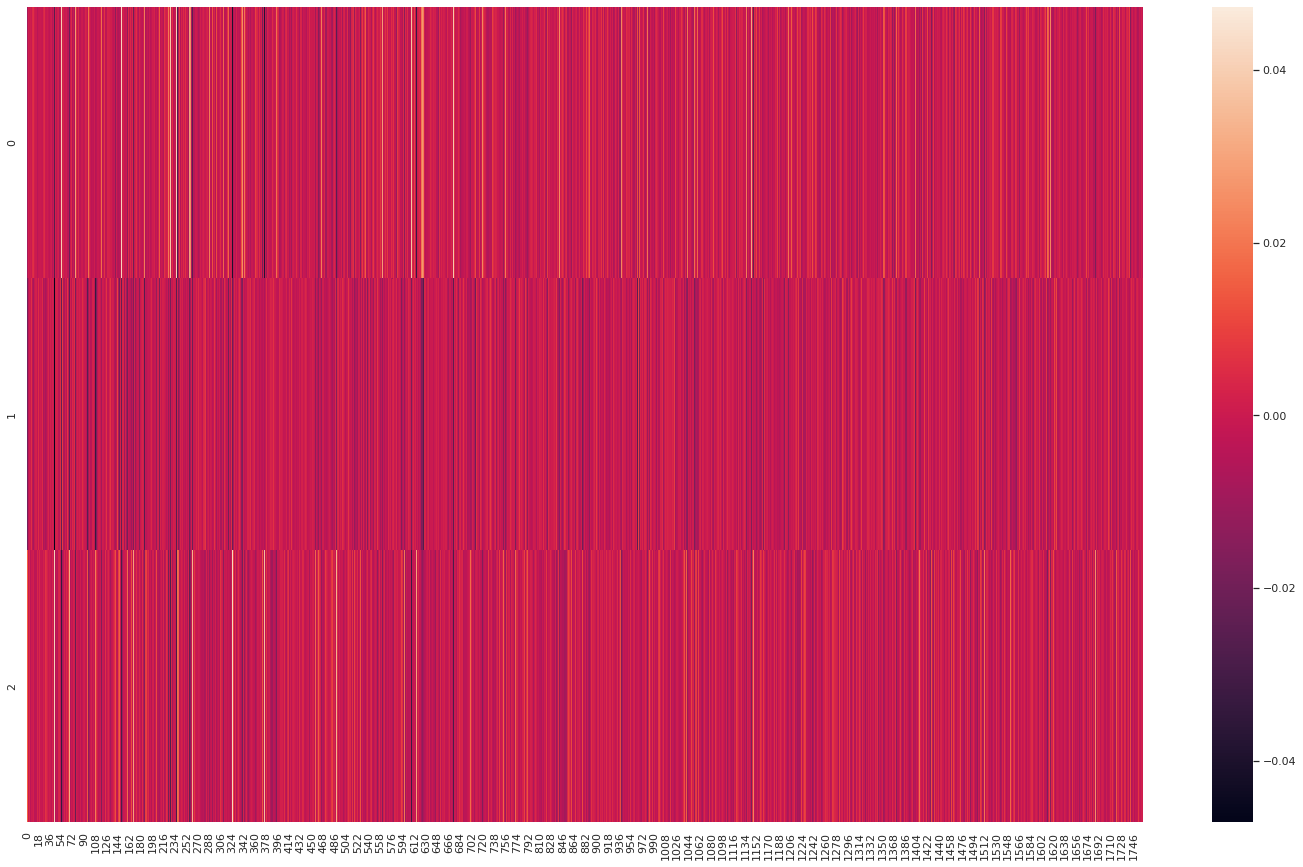

In [330]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron.liste_classifieurs.values()])
sns.heatmap(w)

### Multi classe avec Perceptron Biais

In [331]:
classifierperceptronbiais_1 = ClassifierPerceptronBiais(
    input_dimension=X_train.shape[1], 
    learning_rate=1, 
    batch_size=16, 
    epochs=10
)

multi_classifier_perceptron_biais= ClassifierMultiOAA(
        classifieur= classifierperceptronbiais_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron_biais .train(X_train, y_train)
multi_classifier_perceptron_biais .accuracy(X_test, y_test)


0.8174474959612278


Temps mis --> 2.76795 secondes


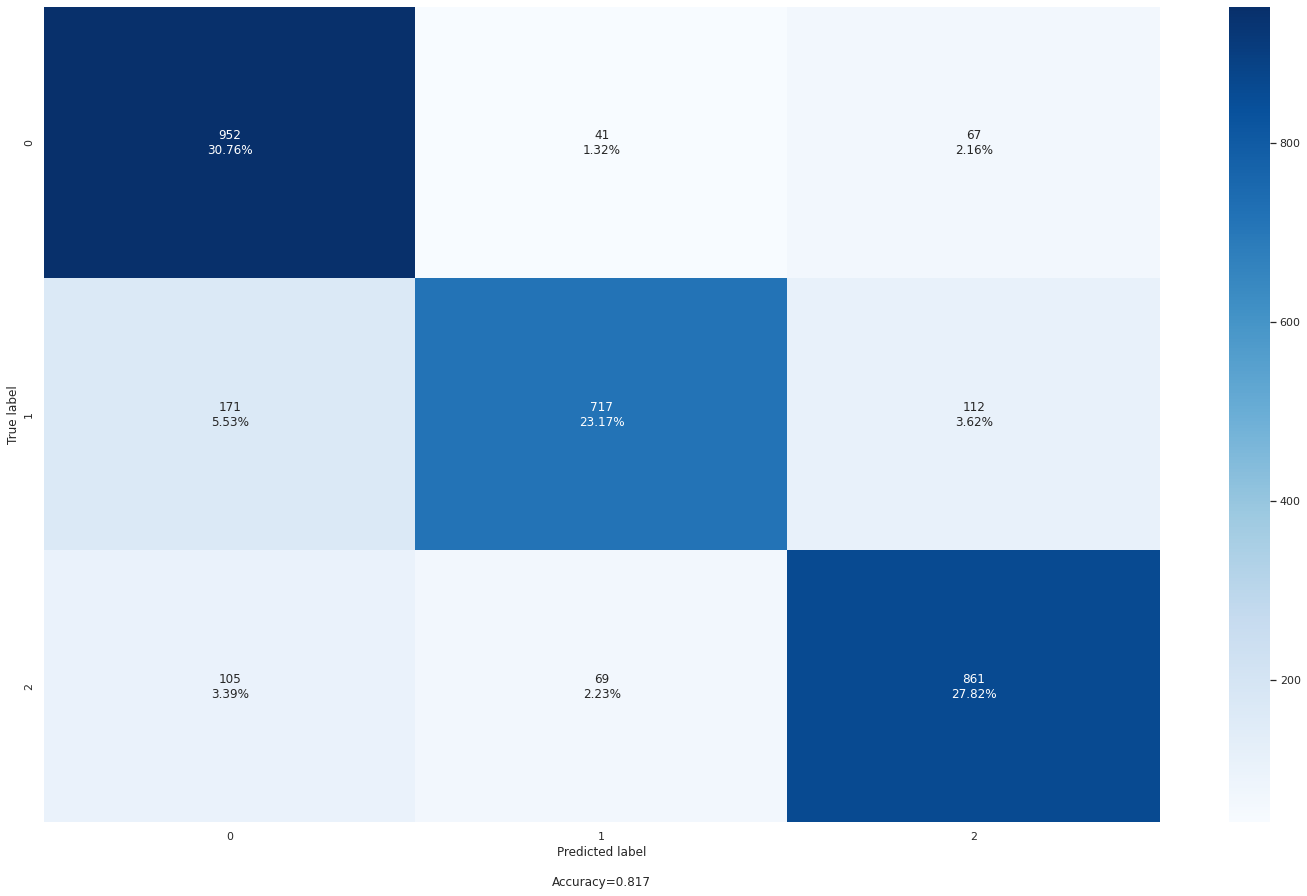

In [332]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron_biais.predict(X_test))

<AxesSubplot:>

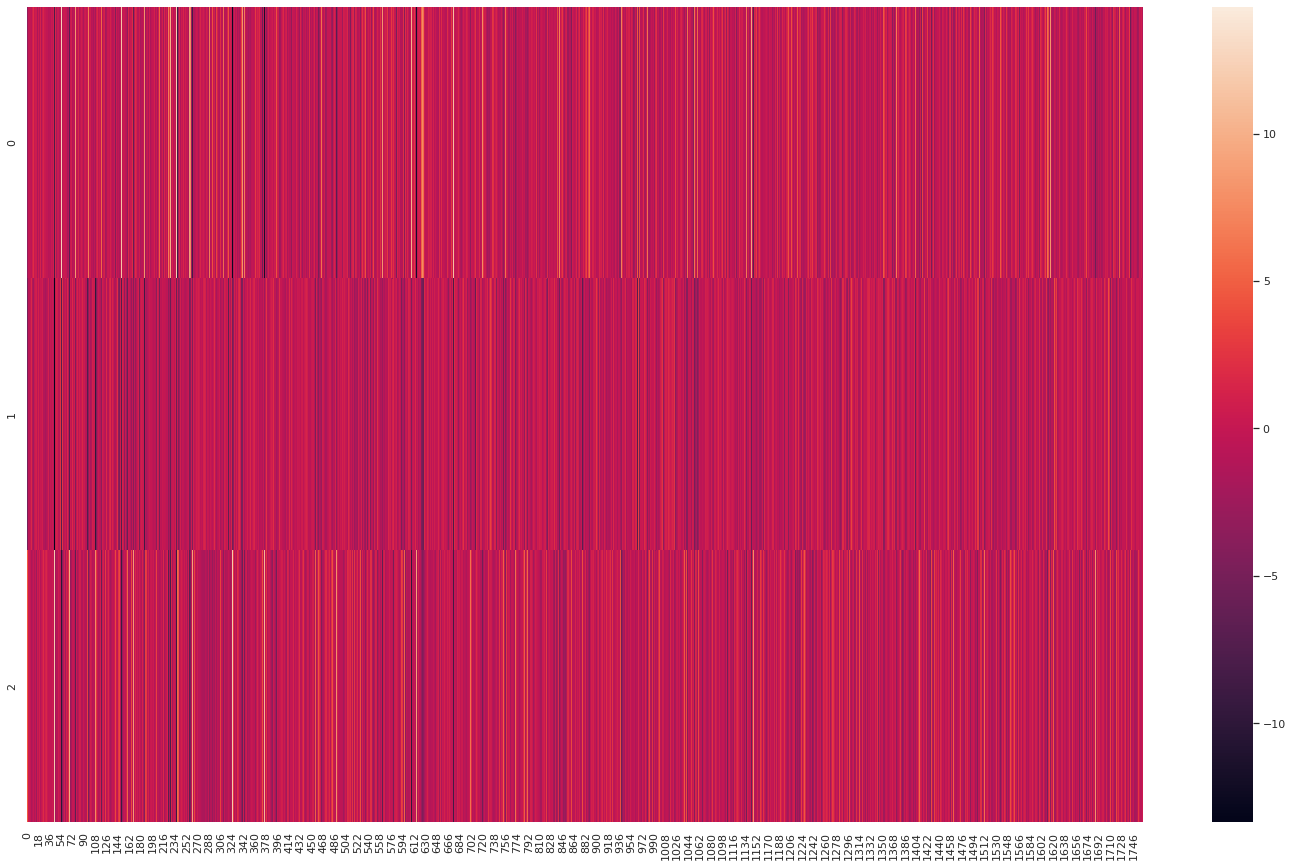

In [334]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron_biais.liste_classifieurs.values()])
sns.heatmap(w)

### Multi classe avec Adaline

In [335]:
classifieradaline_1= ClassifierADALINE(
    input_dimension=X_train.shape[1], 
    learning_rate=1e-4, 
    batch_size=32, 
    epochs=100
)

multi_classifier_perceptron_adaline= ClassifierMultiOAA(
        classifieur= classifieradaline_1,
        input_dimension= X_train.shape[1],
)
tic = timeit.default_timer() # heure de départ
multi_classifier_perceptron_adaline .train(X_train, y_train)
multi_classifier_perceptron_adaline .accuracy(X_test, y_test)



0.7928917609046849


Temps mis --> 12.29934 secondes


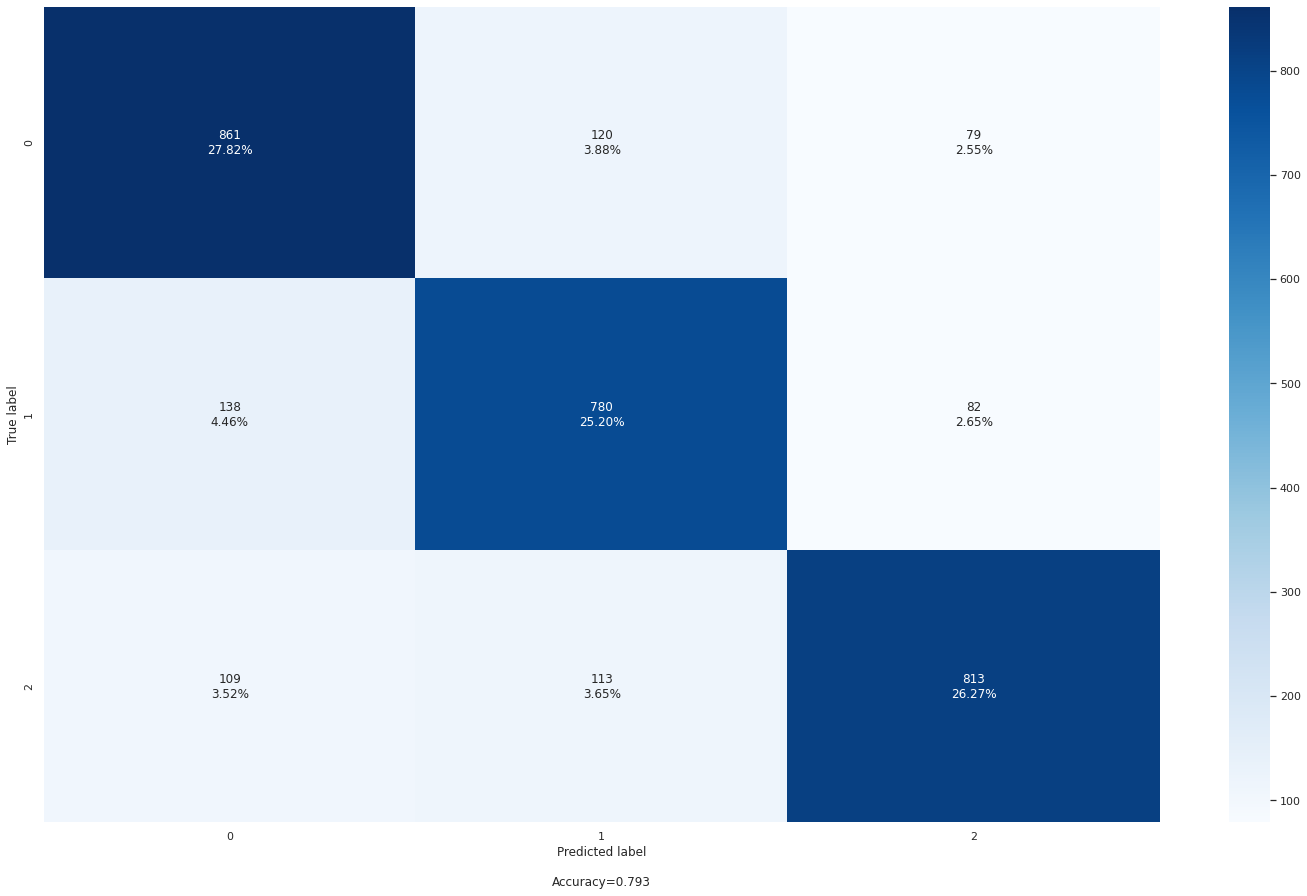

In [336]:
toc = timeit.default_timer() # heure d'arrivée
print(f'\nTemps mis --> {toc-tic:.5f} secondes')
cf_matrix = evaluation.matrix_confusion(y_test, multi_classifier_perceptron_adaline.predict(X_test))

<AxesSubplot:>

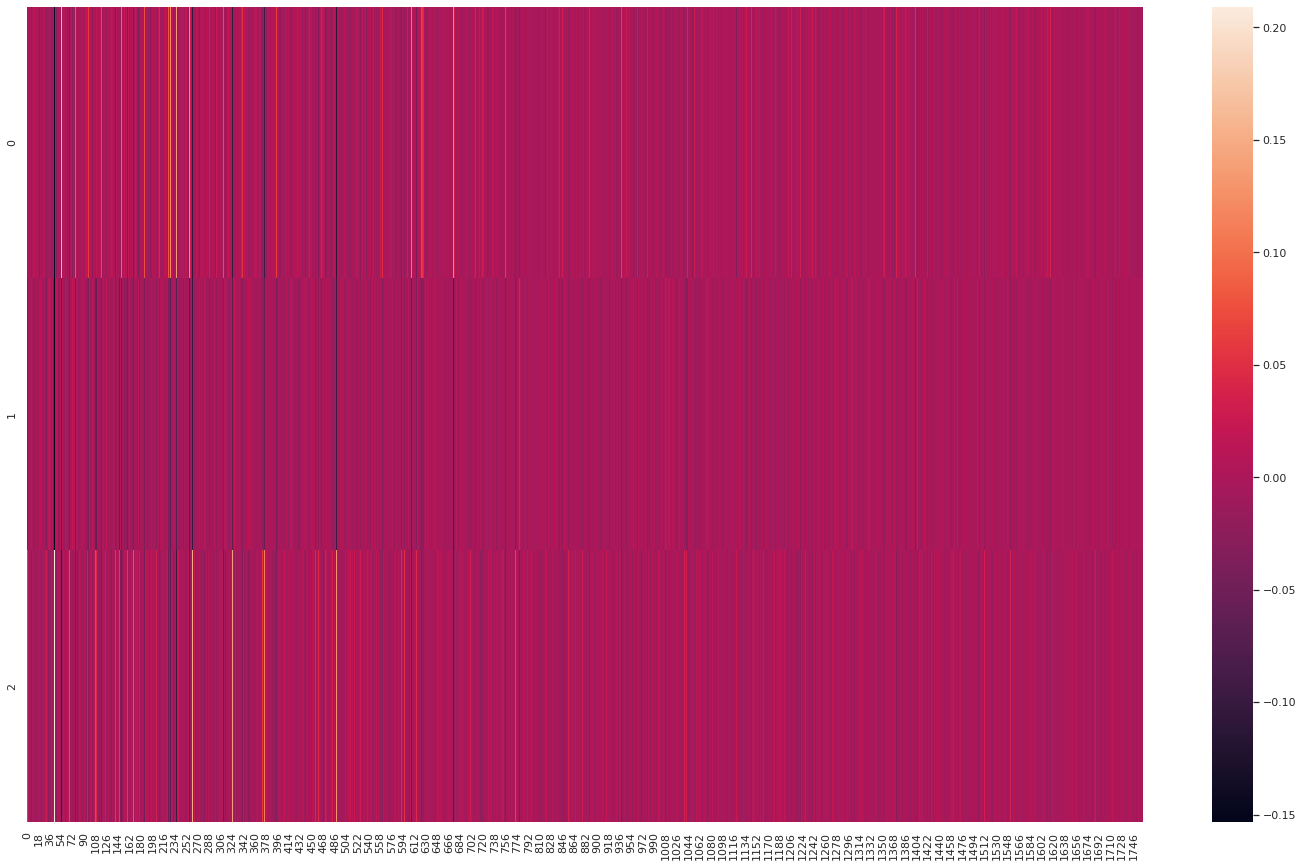

In [337]:
w = np.array([clf.getW().ravel() for clf in multi_classifier_perceptron_adaline.liste_classifieurs.values()])
sns.heatmap(w)

# Comparaison 

D'apres les rélutat des différents classifications avec les différents modèls ont voit que: 
 *  Classification binaire: 
         _ Sur les deux méthodes: CountVectoriser et TFIDFVectoriser les classifier ont des bonne accuracy (entre 71% et 90%)
           à l'exeption random biensur)
           
         _ Sur les deux méthodes: CountVectoriser et TFIDFVectoriser les classifier ont du bon timing entre 0.30s et 0.72 pour tous les calasifieur sauf random et Knn. 
         
        _ Le temps du Knn est suppérieur aux autre dans les deux méthodes . 
         
        _ Tous les clasifieur ont une meilleur acurracy (un tous petit) sur CountVectoriser que TFIDFVectoriser( 
           peut-etre que notre implémentation de TFIDFVectoriser n'est pas bonne !!) 
         

* Multi classification 

      _ Sur les deux méthodes: CountVectoriser et TFIDFVectoriser les classifier ont des bonne accuracy(entre 60% et 85%) à l'exeption de random.
      
     _  Le KNN est le moins perferment sur le TFIDFVectoriser et CountVectoriser (avec 60%)
     
     _ Contrairement à la classification binaire Perceptron et Knn obtiennent des melleirs résultat sur TFIDFVectoriser.
     
       _ ADALINE prends bcp du temps dans TFIDFVectoriser par rapport à CountVectoriser
 
_ Pour que Adaline donne des bonne acurracy il faut donnée un learning rate tres petit pace qu'on a le problème de l'explosion du grandient car la foction du coup qu'on optimise est une fontion au carrée. 
 
_ Tous les classifier prenne plus de temps dans la multi Classification et sur les deux méthode CountVectoriser est TFIDFVectoriser . 

